## Decode Linear Page Address to Page, Block, Plane Index

In [2]:
def decode_page_address(page_address: int, pages_per_block: int, planes: int) -> tuple[int, int, int]:
    """
    Decode a linear page address into (page, block, plane_index)
    
    :param page_address:     The straight page address.
    :param pages_per_block:  Number of pages in each block.
    :param planes:           Number of planes (1, 2, 4, ...).
    
    :return: (page, block, plane_index)
    """
    # 1) Extract 'page' within a block:
    page = page_address % pages_per_block
    
    # 2) Remove 'page' bits to get the combined block/plane field:
    block_plane_field = page_address // pages_per_block
    
    # 3) Extract 'plane_index' from the lower bits:
    #    plane_index = (block_plane_field mod planes) 
    #    because if planes=2 => 1 bit; if planes=4 => 2 bits, etc.
    plane_index = block_plane_field % planes
    
    # 4) "pure block" index :
    block = block_plane_field
    
    #    If you prefer to keep plane bits inside 'block', then do:
    # block = block_plane_field
    
    return (page, block, plane_index)

## Build Address (5 or 3 Cycles)

In [4]:
def build_5_cycle_address(column: int, page: int, block: int, plane: int, lun: int) -> list[int]:
    """
    Build 5 address cycles (bytes) according to the layout:
    1) Column address (16 bits):
       - Cycle 1 => column[7..0]
       - Cycle 2 => column[15..8]
    2) Page address (10 bits total):
       - Cycle 3 => page[7..0]        (lowest 8 bits)
       - Cycle 4 => page[9..8]       (bits [1..0])
    3) Plane (2 bits), embedded in BA[11..10]:
       - Cycle 4 bits [3..2] => plane[1..0]
    4) Block address (10 bits), combined with plane bits => total 12 bits:
       - Cycle 4 bits [7..4] => block[3..0]   (changed as requested)
       - Cycle 5 bits [5..0] => block[9..4]   (changed as requested)
    5) LUN (1 bit):
       - Cycle 5 bit [6] => lun
    :param column: up to 16 bits (0..65535)
    :param page:   up to 10 bits (0..1023)
    :param block:  up to 10 bits (0..1023) – plane bits separate
    :param plane:  0..3 (2 bits)
    :param lun:    0..1 (1 bit)
    :return: List of 5 bytes [cycle1..cycle5].
    """

    # ---------------------
    # Cycle 1 => lower 8 bits of column
    # Cycle 2 => upper 8 bits of column
    # ---------------------
    c1 = column & 0xFF
    c2 = (column >> 8) & 0xFF
    
    # ---------------------
    # Cycle 3 => lower 8 bits of page: page[7..0]
    # ---------------------
    c3 = page & 0xFF
    
    # ---------------------
    # Cycle 4 => c4[7..0]:
    #   bits[7..4] -> block[3..0] 
    #   bits[3..2] -> plane[1..0]
    #   bits[1..0] -> page[9..8]
    # ---------------------
    c4 = 0
    # block[3..0] => lower 4 bits of block
    c4 |= (block & 0xF) << 4
    # plane => 2 bits in [3..2]
    c4 |= (plane & 0x3) << 2
    # top 2 bits of page => page[9..8]
    c4 |= (page >> 8) & 0x3
    
    
    # ---------------------
    # Cycle 5 => c5[7..0]:
    #   bits[5..0] -> block[9..4]
    #   bit [6]    -> lun
    #   bit [7]    -> 0
    # ---------------------
    c5 = 0
    # block[9..4] => 6 bits
    c5 |= ((block >> 4) & 0x3F)
    # lun => bit [6]
    c5 |= ((lun & 0x1) << 6)
    
    return [c1, c2, c3, c4, c5]

In [5]:
def build_3_cycle_address(page: int, block: int, plane: int, lun: int) -> list[int]:
    
    # ---------------------
    # Cycle 1 => lower 8 bits of page: page[7..0]
    # ---------------------
    c1 = page & 0xFF
    
    # ---------------------
    # Cycle 2 => c4[7..0]:
    #   bits[7..4] -> block[3..0] 
    #   bits[3..2] -> plane[1..0]
    #   bits[1..0] -> page[9..8]
    # ---------------------
    c2 = 0
    # block[3..0] => lower 4 bits of block
    c2 |= (block & 0xF) << 4
    # plane => 2 bits in [3..2]
    c2 |= (plane & 0x3) << 2
    # top 2 bits of page => page[9..8]
    c2 |= (page >> 8) & 0x3
    
    
    # ---------------------
    # Cycle 3 => c5[7..0]:
    #   bits[5..0] -> block[9..4]
    #   bit [6]    -> lun
    #   bit [7]    -> 0
    # ---------------------
    c3 = 0
    # block[9..4] => 6 bits
    c3 |= ((block >> 4) & 0x3F)
    # lun => bit [6]
    c3 |= ((lun & 0x1) << 6)
    
    return [c1, c2, c3]

In [6]:
def build_5_cycle_address_tlc(column: int, page: int, block: int, plane: int, lun: int) -> list[int]:
    c1 = column & 0xFF
    c2 = (column >> 8) & 0xFF
    
    c3 = page & 0xFF
    
    c4 = 0
    c4 |= (block & 0x7) << 5
    c4 |= (plane & 0x1) << 4
    c4 |= (page >> 8) & 0xF
    
    c5 = 0
    c5 |= ((block >> 3) & 0x3F)
    c5 |= ((lun & 0x1) << 6)
    
    return [c1, c2, c3, c4, c5]

In [7]:
def build_3_cycle_address_tlc(page: int, block: int, plane: int, lun: int) -> list[int]:
    c1 = page & 0xFF
    
    c2 = 0
    c2 |= (block & 0x7) << 5
    c2 |= (plane & 0x1) << 4
    c2 |= (page >> 8) & 0xF
    
    c3 = 0
    c3 |= ((block >> 3) & 0x3F)
    c3 |= ((lun & 0x1) << 6)

    return [c1, c2, c3]

## Commands for Nand Flash and FTDI

In [8]:
#FTDI Commands
ACTIVATE_COMMNAD_LATCH = 0x40
ACTIVATE_ADDRESS_LATCH = 0x80
ACTIVATE_WRITE_PROTECT = 0x20
DEACTIVATE_CA_LATCH = 0x00

#Nand Flash Commands
NAND_CMD_READ_CYCLE1 = 0x00
NAND_CMD_READ_CYCLE2 = 0x30

NAND_CMD_PROGRAM_CYCLE1 = 0x80
NAND_CMD_PROGRAM_CYCLE2 = 0x10

NAND_CMD_BLOCK_ERASE_CYCLE1 = 0x60
NAND_CMD_BLOCK_ERASE_CYCLE2 = 0xD0

NAND_CMD_RESET = 0xFF
NAND_CMD_READ_STATUS = 0x70

WR_ADDRESS_CYCLE = 5
ERASE_ADDRESS_CYCLE = 3

## Nand Read Page Functions

In [9]:
def read_nand_command (cycle):
    #Command Cycle 1
    cmds1 = [Ftdi.WRITE_EXTENDED, ACTIVATE_COMMNAD_LATCH, 0] 
    cmds1 += [NAND_CMD_READ_CYCLE1]
    ftdi.write_data(Array('B', cmds1))
    
    #Address Cycle 5 Consequtive
    cmds2 = [Ftdi.WRITE_EXTENDED, ACTIVATE_ADDRESS_LATCH, 0 , cycle[0]]
    for i in range(1,WR_ADDRESS_CYCLE,1):
        cmds2 += [Ftdi.WRITE_SHORT, 0, cycle[i]]
    ftdi.write_data(Array('B', cmds2))
    
    #Command Cycle 2
    cmds3 = [Ftdi.WRITE_EXTENDED, ACTIVATE_COMMNAD_LATCH, 0]
    cmds3 += [NAND_CMD_READ_CYCLE2]
    ftdi.write_data(Array('B', cmds3))
    
    
    #print(f"Command 1:  {cmds1}")
    #print(f"Command 2:  {cmds2}")
    #print(f"Command 3:  {cmds3}")

In [11]:
def read_nand_page_bytes(read_len):
    cmds = []
    
    #Data Read Cycle
    cmds += [ftdi.READ_EXTENDED, DEACTIVATE_CA_LATCH , 0]
    
    for i in range(1, read_len, 1):
        cmds += [Ftdi.READ_SHORT, 0]
        
    cmds.append(Ftdi.SEND_IMMEDIATE)
    ftdi.write_data(Array('B', cmds))
    data = ftdi.read_data_bytes(read_len)
    return bytes(data)

## NAND Write Page Functions

In [12]:
def program_nand_page(cycle, data):
    #Command Cycle 1
    activateCMD = ACTIVATE_WRITE_PROTECT | ACTIVATE_COMMNAD_LATCH
    cmds1 = [Ftdi.WRITE_EXTENDED, activateCMD, 0] 
    cmds1 += [NAND_CMD_PROGRAM_CYCLE1]
    
    #Address Cycle 5 Consequtive
    activateADR = ACTIVATE_WRITE_PROTECT | ACTIVATE_ADDRESS_LATCH
    cmds2 = [Ftdi.WRITE_EXTENDED, activateADR, 0 , cycle[0]]
    for i in range(1,WR_ADDRESS_CYCLE,1):
        cmds2 += [Ftdi.WRITE_SHORT, 0, cycle[i]]
    
    #data cycle 
    activateDTC = ACTIVATE_WRITE_PROTECT | DEACTIVATE_CA_LATCH
    cmds3 = [Ftdi.WRITE_EXTENDED, activateDTC , 0, data[0]]
    for i in range(1,len(data),1):
        cmds3 += [Ftdi.WRITE_SHORT, 0, data[i]]
    
    #Command Cycle 2
    activateCMD = ACTIVATE_WRITE_PROTECT | ACTIVATE_COMMNAD_LATCH
    cmds4 = [Ftdi.WRITE_EXTENDED, activateCMD, 0]
    cmds4 += [NAND_CMD_PROGRAM_CYCLE2]
    
    #print(f"Command 1:  {cmds1}")
    #print(f"Command 2:  {cmds2}")
    #print(f"Command 3:  {cmds3}")
    #print(f"Command 4:  {cmds4}")
    
    ftdi.write_data(Array('B', cmds1))
    time.sleep(0.01)
    ftdi.write_data(Array('B', cmds2))
    time.sleep(0.01)
    ftdi.write_data(Array('B', cmds3))
    time.sleep(0.01)
    ftdi.write_data(Array('B', cmds4))
    time.sleep(0.01)

In [13]:
def status_register_check():
    #Staus Cycle
    cmds1 = [Ftdi.WRITE_EXTENDED, ACTIVATE_COMMNAD_LATCH, 0]
    cmds1 += [NAND_CMD_READ_STATUS]
    ftdi.write_data(Array('B', cmds1))
    #print(f"Command 5:  {cmds1}")
        
    cmds1 = [ftdi.READ_EXTENDED, DEACTIVATE_CA_LATCH , 0]
    cmds1 += [Ftdi.READ_SHORT, 0]
        
    cmds1.append(Ftdi.SEND_IMMEDIATE)
    ftdi.write_data(Array('B', cmds1))
    
    status = ftdi.read_data_bytes(1)
    state = ord(status)
    print(status)
    print(f"Status:{state:08b}")
    if state == 96:
        print("Successfully Done!!")
    else:
        print("failed, check the status byte")

In [14]:
def createDataStream(sizeDataArray):
    dataStream = []
    data = 0
    for i in range(0, sizeDataArray, 1):
        data += 1
        dataStream.append(data)
        if (data >= 8):
            data = 0
    print(len(dataStream))
    return dataStream

In [15]:
def createDataStreamZeros(sizeZerosArray):
    dataStream = []
    for i in range(0, sizeZerosArray, 1):
        dataStream.append(0)
    #print(len(dataStream))
    #print(dataStream)
    return dataStream

In [16]:
def createCharacterStream(sizechrArray):
    chrStream = ""
    data = 0
    for i in range(0, sizechrArray, 1):
        data = "A"
        chrStream += data
    print(len(chrStream))
    print(chrStream)
    return chrStream

## NAND Erase Block Functions

In [17]:
def erase_nand_block (cycle):
    #Command Cycle 1
    activateCMD = ACTIVATE_WRITE_PROTECT | ACTIVATE_COMMNAD_LATCH
    cmds1 = [Ftdi.WRITE_EXTENDED, activateCMD, 0] 
    cmds1 += [NAND_CMD_BLOCK_ERASE_CYCLE1]
    
    #Address Cycle 3 Consequtive
    activateADR = ACTIVATE_WRITE_PROTECT | ACTIVATE_ADDRESS_LATCH
    cmds2 = [Ftdi.WRITE_EXTENDED, activateADR, 0 , cycle[0]]
    for i in range(1,ERASE_ADDRESS_CYCLE,1):
        cmds2 += [Ftdi.WRITE_SHORT, 0, cycle[i]]
    
    #Command Cycle 2
    activateCMD = ACTIVATE_WRITE_PROTECT | ACTIVATE_COMMNAD_LATCH
    cmds3 = [Ftdi.WRITE_EXTENDED, activateCMD, 0]
    cmds3 += [NAND_CMD_BLOCK_ERASE_CYCLE2]
    
    print(f"Command 1:  {cmds1}")
    print(f"Command 2:  {cmds2}")
    print(f"Command 4:  {cmds3}")
    
    ftdi.write_data(Array('B', cmds1))
    ftdi.write_data(Array('B', cmds2))
    ftdi.write_data(Array('B', cmds3))
    time.sleep(1)

## FTDI Initialization

In [18]:
#essential functions
import usb.core
import usb.util
import time
from array import array as Array
from pyftdi.ftdi import *

In [19]:
def initializeFTDI(ftdi):
    #essential functions
    VENDOR_ID = 0x0403
    PRODUCT_ID = 0x6010

    # direction_mask: 1 means output, 0 means input
    # value_mask:     1 sets the pin high, 0 sets it low
    DIRECTION_MASK = 0xFF  # all upper 8 bits as output
    VALUE_MASK = 0x00     # pattern to set the pins to

    #Open a new interface to the specified FTDI device.
    #open() method establishes a connection to a specific FTDI device.
    ftdi.open(VENDOR_ID, PRODUCT_ID, interface=1)

    #Configures the FTDI device into MCU Host Bus Emulation mode
    ftdi.set_bitmode(0x00, Ftdi.BitMode.MCU)  # MCU = 0x08 (MCU Host Bus Emulation mode)

    #Disable the “divide-by-5” clock prescaler allows higher frequency operation
    ftdi.write_data(Array('B', [Ftdi.DISABLE_CLK_DIV5]))

    #the FTDI device waits (in milliseconds) 
    #before sending any partially filled USB packet up to the host if the buffer is not yet full.
    ftdi.set_latency_timer(2)


    # This tells the FTDI chip to set upper 8 bits with these direction and value settings
    ftdi.write_data(bytes([
    Ftdi.SET_BITS_HIGH,
    VALUE_MASK,
    DIRECTION_MASK
    ]))

    #Any pending outbound data in the transmit buffer is cleared
    ftdi.purge_buffers()

    #Reset the the nand flash chip
    cmdsRST = [Ftdi.WRITE_EXTENDED, ACTIVATE_COMMNAD_LATCH, 0, NAND_CMD_RESET]
    print (cmdsRST)
    ftdi.write_data(Array('B', cmdsRST))

In [20]:
# Initialize FTDI
#Creates an instance or object of the Ftdi class and stored in the ftdi variable
ftdi = Ftdi()
initializeFTDI(ftdi)

[147, 64, 0, 255]


# MAIN CODE: Read, Write, Erase Operations of Nand Flash Memory

## Read Page Byte by Byte

In [21]:
#convert linear page address
linearPageAddress = 121
pagesPerBlock = 1024
NumberOfPlane = 4

pageX, blockX, planeX = decode_page_address(linearPageAddress, pagesPerBlock, NumberOfPlane)

print(f"Address {linearPageAddress} => Page {pageX}, Block {blockX}, Plane {planeX}")

Address 121 => Page 121, Block 0, Plane 0


In [22]:
#create address cycle
column = 0
page   = pageX
block  = blockX
plane  = planeX
lun    = 0

#create 5 address cycle
cycles = build_5_cycle_address(column, page, block, plane, lun)
print(f"Address Cycles: {cycles}")

print("5 Address Cycles:")
for i, val in enumerate(cycles, start=1):
    print(f" Cycle {i}: 0x{val:02X}  (bin: {val:08b})")


Address Cycles: [0, 0, 121, 0, 0]
5 Address Cycles:
 Cycle 1: 0x00  (bin: 00000000)
 Cycle 2: 0x00  (bin: 00000000)
 Cycle 3: 0x79  (bin: 01111001)
 Cycle 4: 0x00  (bin: 00000000)
 Cycle 5: 0x00  (bin: 00000000)


In [24]:
byteLength = 1000

#Send the command and address cycles before page read
read_nand_command(cycles)

#Read byte by byte from Data Register
read_nand_page_bytes(byteLength)

b'\x88\xdb\x01@Mc\x93\xe9\xdd\xce\n\xad\x04hxwB"Vf\xe1o\xe61\x8b\x9f\xceNODB0,\xb9\xd1\x1fQ-\xbdg\xc8T\xbaN\xa4\xd2\r\x07\xc2m\x97"\xfajT^\x1a\xd5\x9ce\xf3\xb39#`VWh`\xc3\xdaF\xd1U\x9f2\x01\xfaC\xc5\x85\xf9\xba\x10`\xd1\x93\xf68\x0b\xfd\x1f\xe7\xe7\xe4qT?@jO\xc8, L\x9d0]*P \xef\xd2=Q\xab\xc7qD$\x18\xe1`\x96\xf0\xcf\xd2\x8a\xf0\x98\x18\x1a\x00\xc3\x8b\x996\x18\xd2\x8f-\xdd\x11=\x1c\x9f\xee\x96O\x82\xd6\x991B\x84\x01l,h\x08%\xda\xaa\x01\xd2\xd3\x105\xfb\xd1G\xee\x00\x81\x9a\x95b3Z\xd9W\x99\xbag\x0b\xa8E\xe1<*TA\xe4h\x9d_\xd3\x04\xa0\x01\x17N\xd3\r\xfc \xea\x85\xf3\x05%\xdb\x0c\xd3\xd9\xbe\x1a\xf9\xdb]<\x0c\xef\nx\xbd\xa62\x9e\xb63\xe2O6\xd5\x98\xf0\x01\x97\xe67\xd9\x80q\xcc\xf0v\x9e\xcf\xe0!\x1br|\xe2\x98\xcd~\x83DN\x9f\xcb\xcd\x1fV\xb1\x1aZz\x99\xb9\xbfJ\xc3k\xf9\x91DG\xbc\xba\x94\x96v\xc6=\xdb\xd7G\x91\x1e:!M8~\xd1R\xdd\xab\xf2\xf7\x85\x8d\';\xeb;\xca\x91\x7f9T\xc5#6\t\xb09\x82\xb3g\x14\x82\xd1T4\x8a\xdeU\xb9\xe3\xc1\xec{\xc7\x05{\xdfX$\xd5\xae\xdc\'\\t\xa7\xa8B\xe9\xa0\xd81\xd4\xc6\x1

In [25]:
byteLength = 1000

#Send the command and address cycles before page read
read_nand_command(cycles)

#Read byte by byte from Data Register
read_nand_page_bytes(byteLength)

b'\x88\xdb\x01@Mc\x93\xe9\xdd\xce\n\xad\x04hxwB"Vf\xe1o\xe61\x8b\x9f\xceNODB0,\xb9\xd1\x1fQ-\xbdg\xc8T\xbaN\xa4\xd2\r\x07\xc2m\x97"\xfajT^\x1a\xd5\x9ce\xf3\xb39#`VWh`\xc3\xdaF\xd1U\x9f2\x01\xfaC\xc5\x85\xf9\xba\x10`\xd1\x93\xf68\x0b\xfd\x1f\xe7\xe7\xe4qT?@jO\xc8, L\x9d0]*P \xef\xd2=Q\xab\xc7qD$\x18\xe1`\x96\xf0\xcf\xd2\x8a\xf0\x98\x18\x1a\x00\xc3\x8b\x996\x18\xd2\x8f-\xdd\x11=\x1c\x9f\xee\x96O\x82\xd6\x991B\x84\x01l,h\x08%\xda\xaa\x01\xd2\xd3\x105\xfb\xd1G\xee\x00\x81\x9a\x95b3Z\xd9W\x99\xbag\x0b\xa8E\xe1<*TA\xe4h\x9d_\xd3\x04\xa0\x01\x17N\xd3\r\xfc \xea\x85\xf3\x05%\xdb\x0c\xd3\xd9\xbe\x1a\xf9\xdb]<\x0c\xef\nx\xbd\xa62\x9e\xb63\xe2O6\xd5\x98\xf0\x01\x97\xe67\xd9\x80q\xcc\xf0v\x9e\xcf\xe0!\x1br|\xe2\x98\xcd~\x83DN\x9f\xcb\xcd\x1fV\xb1\x1aZz\x99\xb9\xbfJ\xc3k\xf9\x91DG\xbc\xba\x94\x96v\xc6=\xdb\xd7G\x91\x1e:!M8~\xd1R\xdd\xab\xf2\xf7\x85\x8d\';\xeb;\xca\x91\x7f9T\xc5#6\t\xb09\x82\xb3g\x14\x82\xd1T4\x8a\xdeU\xb9\xe3\xc1\xec{\xc7\x05{\xdfX$\xd5\xae\xdc\'\\t\xa7\xa8B\xe9\xa0\xd81\xd4\xc6\x1

## Program Pages in a Block

In [31]:
linearPageAddress = 121
pagesPerBlock = 1024
NumberOfPlane = 4

pageX, blockX, planeX = decode_page_address(linearPageAddress, pagesPerBlock, NumberOfPlane)
addressCycleStream = build_5_cycle_address(0, pageX, blockX, planeX, 0)

In [32]:
pageBytes = 16384
data = createDataStream(pageBytes)

program_nand_page (addressCycleStream, data)

status_register_check()

16384
bytearray(b'`')
Status:01100000
Successfully Done!!


In [34]:
ftdi.purge_buffers()
read_nand_command(addressCycleStream)
read_nand_page_bytes(100)

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'

## Erase a Block

In [50]:
linearPageAddress = 121
pagesPerBlock = 1024
NumberOfPlane = 4

pageX, blockX, planeX = decode_page_address(linearPageAddress, pagesPerBlock, NumberOfPlane)
print(f"Address {linearPageAddress} => Page {pageX}, Block {blockX}, Plane {planeX}")

blockEraseAddress = build_3_cycle_address(pageX, blockX, planeX, 0)

print("3 Address Cycles:")
for i, val in enumerate(blockEraseAddress, start=1):
    print(f" Cycle {i}: 0x{val:02X}  (bin: {val:08b})")

Address 121 => Page 121, Block 0, Plane 0
3 Address Cycles:
 Cycle 1: 0x79  (bin: 01111001)
 Cycle 2: 0x00  (bin: 00000000)
 Cycle 3: 0x00  (bin: 00000000)


In [51]:
erase_nand_block (blockEraseAddress)

status_register_check()

Command 1:  [147, 96, 0, 96]
Command 2:  [147, 160, 0, 121, 146, 0, 0, 146, 0, 0]
Command 4:  [147, 96, 0, 208]
bytearray(b'`')
Status:01100000
Successfully Done!!


In [54]:
ftdi.purge_buffers()
read_nand_command(addressCycleStream)
read_nand_page_bytes(100)

b'\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff'

In [ ]:
#ftdi.close();

## Program a block

In [35]:
def program_block_zeros(pagePerBlock):
    pageno = 0
    blockno = 0
    planeno = 0
    pageBytes = 16384
    for i in range(0, pagePerBlock, 1):
        pageno = i
        addressCycleStream = build_5_cycle_address(0, pageno, blockno, planeno, 0)
        data = createDataStreamZeros(pageBytes)
        program_nand_page (addressCycleStream, data)
    status_register_check()

In [61]:
program_block_zeros(1024)

Status:01100000
Successfully Done!!


In [26]:
def nand_read_full_page(pageno, blockno, PagePerBlock):
    planeno = 0
    pageBytes = 16384
    max_rx_buffer = 4096
    readData = []
    ftdi.purge_buffers()

    addressCycleStream = build_5_cycle_address(0, pageno, blockno, planeno, 0)
    read_nand_command(addressCycleStream)

    for i in range(0, pageBytes//max_rx_buffer, 1):
        readData += read_nand_page_bytes(max_rx_buffer)
    readData += read_nand_page_bytes(pageBytes%max_rx_buffer)

    #Check the Programmed Page
    #print(len(readData))
    #print(type(readData))

    #for i in range(1, 16384, 1):
        #print(readData[i], end=" ")

    return readData

In [28]:
#nand_read_full_page(0, 0, 1024)

## Failure Bit Count: Programmed using All Zero Data

In [37]:
def count_failing_bits_in_page(page_data):
    """
    Given a list of bytes (page_data), count the total number of bits that are 1.
    """
    failing_bits = 0
    for byte_val in page_data:
        # Convert to binary string, then count how many '1' bits appear
        failing_bits += bin(byte_val).count('1')
    return failing_bits

In [38]:
def count_fbc(start_page, end_page, byte_to_write, fd):
    """
    Count the Failed Bit Count (FBC) from start_page to end_page
    and write the results to the provided file descriptor (fd).
    """

    page_per_block = 1024
    current_block = start_page // page_per_block
    fd.write(f"Block = {current_block}\n")
    pageFBC1 = []
    pageFBC2 = []
    pageFBC3 = []
    pageFBC4 = []

    block_fbc_count = 0
    page_data = bytes()
    # Read each page in the specified range
    for page_index in range(start_page, end_page):
        # Read data for the current page
        page_data = nand_read_full_page(page_index, current_block)
        
        # Count non-zero bytes
        page_fbc_count = count_failing_bits_in_page(page_data)
        if (page_fbc_count == 1):
            pageFBC1 += [ page_index ]
        elif (page_fbc_count == 2):
            pageFBC2 += [ page_index ]
        elif (page_fbc_count == 3):
            pageFBC3 += [ page_index ]
        elif (page_fbc_count == 4):
            pageFBC3 += [ page_index ]

        # Write page-level FBC and raw data
        fd.write(f"Page = {page_index}, FBC = {page_fbc_count}, ")
        fd.write(",".join(str(b) for b in page_data))
        fd.write("\n")

        block_fbc_count += page_fbc_count

        # Check if we've crossed into a new block
        new_block = page_index // page_per_block
        if new_block != current_block:
            # Reset for the new block
            block_fbc_count = page_fbc_count
            current_block = new_block
    #print(len(page_data))
    #print(page_data)
    print("FBC Process Completed")
    print ("FBC1:", end=" ")
    print (pageFBC1)
    print ("FBC2:", end=" ")
    print (pageFBC2)
    print ("FBC3:", end=" ")
    print (pageFBC3)
    print ("FBC4:", end=" ")
    print (pageFBC4)

    return pageFBC1, pageFBC2, pageFBC3 ,pageFBC4 

In [36]:
# Specify your desired start and end pages
start_page = 0
end_page = 1024

# This is just a dummy value for 'byte_to_write'—you can set this as needed
byte_to_write = 0

# Open a file for logging
with open("CHECK_FBC_BITS_MLC_1.txt", "w") as fd:
    # Call the method, passing in your parameters and file descriptor
    fbc1_pages, fbc2_pages, fbc3_pages, fbc4_pages = count_fbc(start_page, end_page, byte_to_write, fd)

print("Done. Check 'CHECK_FBC_BITS_MLC_1.txt' for results.")

FBC Process Completed
FBC1: [48, 49, 52, 54, 55, 64, 66, 68, 71, 78, 86, 90, 94, 95, 104, 112, 114, 116, 122, 124, 126, 130, 132, 134, 137, 140, 142, 148, 153, 156, 157, 159, 162, 172, 173, 174, 177, 179, 181, 185, 187, 189, 194, 200, 202, 210, 214, 216, 220, 224, 228, 230, 237, 250, 256, 270, 278, 289, 290, 291, 296, 298, 300, 302, 304, 308, 310, 312, 316, 322, 323, 324, 332, 334, 348, 350, 355, 358, 364, 383, 385, 390, 398, 415, 418, 424, 434, 435, 442, 444, 451, 452, 461, 474, 480, 481, 482, 490, 498, 502, 503, 506, 522, 528, 540, 542, 544, 546, 548, 555, 568, 570, 579, 586, 590, 600, 606, 614, 620, 622, 623, 628, 634, 650, 652, 660, 666, 682, 692, 694, 699, 712, 728, 729, 730, 742, 744, 754, 757, 760, 764, 770, 782, 792, 796, 799, 802, 804, 812, 814, 820, 824, 829, 830, 832, 850, 851, 854, 861, 865, 866, 868, 870, 893, 894, 904, 910, 916, 918, 920, 924, 930, 931, 932, 944, 946, 950, 951, 954, 964, 980, 992, 994, 995, 996, 1000, 1006, 1020]
FBC2: [70, 72, 98, 110, 118, 136, 144, 154

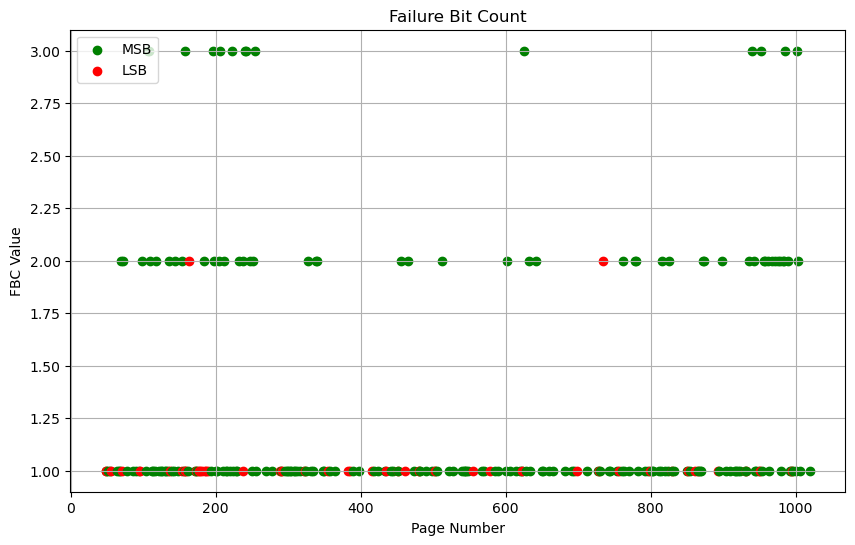

In [38]:
import matplotlib.pyplot as plt

# Dictionary of FBC -> [page indices]
fbc_dict = {
    1: fbc1_pages,
    2: fbc2_pages,
    3: fbc3_pages,
    4: fbc4_pages,
}

plt.figure(figsize=(10, 6))

# Plot each page with the corresponding FBC
for fbc_value, pages in fbc_dict.items():
    for page in pages:
        marker_style = 'o' if page % 2 == 0 else 'o'
        color = 'green' if page % 2 == 0 else 'red'
        plt.scatter(page, fbc_value, c=color, marker=marker_style)

# Create invisible points just for the legend
#   - MSB => green 'o'
#   - LSB => red 'o'
plt.scatter([], [], c='green', marker='o', label='MSB')
plt.scatter([], [], c='red', marker='o', label='LSB')

plt.title("Failure Bit Count")
plt.xlabel("Page Number")
plt.ylabel("FBC Value")
plt.grid(True)
plt.legend(loc='upper left')

# Save the figure with high resolution (e.g., 300 dpi)
plt.savefig("failure bit count.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

## Failure Bit Count: Programmed using Random Data

In [35]:
import random

def create_nand_random_file(filename, num_pages=1025, page_size=16384):
    """
    Create a text file with random data mimicking a NAND flash structure.

    :param filename: Output file name
    :param num_pages: Number of pages to write (P0 through P(num_pages-1))
    :param page_size: Number of random bytes (0-255) per page
    """
    with open(filename, 'w') as f:
        for page_idx in range(num_pages):
            # Write page identifier
            f.write(f"P{page_idx} = ")
            
            # Generate random values for this page
            random_values = [random.randint(0, 255) for _ in range(page_size)]
            
            # Convert list to comma-delimited string enclosed by brackets
            page_data = "[" + ",".join(map(str, random_values)) + "]"
            
            # Write data to file
            f.write(page_data + "\n\n")  # Blank line after each page for readability


In [44]:
create_nand_random_file("nand_random_data.txt", num_pages=1024, page_size=16384)

In [34]:
def read_random_values(filename):
    """
    Reads random data from a file containing lines in the format:
        P0 = [val1,val2,val3,...]
        P1 = [val1,val2,val3,...]
    Returns a list of lists (each sub-list is one page of data).
    """
    random_data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            # We only parse lines that have the pattern "P<number> = [ ... ]"
            if line.startswith("P") and "=" in line:
                # Example line: "P0 = [1,2,3,4]"
                # Split at "="
                _, right_side = line.split("=", maxsplit=1)
                # right_side is now "[1,2,3,4]"
                array_str = right_side.strip()
                # Remove the surrounding brackets []
                array_str = array_str.strip("[]")
                # Split by comma to get each value as a string
                values_str = array_str.split(",")
                # Convert each string to an integer
                values = list(map(int, values_str))
                random_data.append(values)
    return random_data


In [36]:
randomData = read_random_values("nand_random_data.txt")

print (randomData[0][0])
print (len(randomData[1023]))

76
16384


In [37]:
def program_block_with_random_data(filename):
    # Read all random data from the file into a list of pages
    all_pages_data = read_random_values(filename)
    
    pagePerBlock = 1024
    blockno = 0
    planeno = 0
    pageBytes = 16384  # Make sure this matches the length of data in each page
    
    # Safety check: ensure we have at least 1024 pages worth of data
    if len(all_pages_data) < pagePerBlock:
        raise ValueError(
            f"Not enough pages in file! "
            f"Expected at least {pagePerBlock}, got {len(all_pages_data)}"
        )

    # Iterate through each page in the block
    for pageno in range(pagePerBlock):
        # Build the address for page pageno in blockno
        addressCycleStream = build_5_cycle_address(0, pageno, blockno, planeno, 0)
        
        # Get the data for this page
        data = all_pages_data[pageno]
        
        # Check that the page data matches pageBytes in length
        if len(data) != pageBytes:
            raise ValueError(
                f"Page {pageno} has {len(data)} bytes, expected {pageBytes} bytes."
            )
        
        # Program the page
        program_nand_page(addressCycleStream, data)
    
    # After programming all pages in the block, check status
    status_register_check()


In [48]:
program_block_with_random_data("nand_random_data.txt")

Status:01100000
Successfully Done!!


In [49]:
programData = nand_read_full_page(0, 0)
print(programData[0])
len(programData)

76


16384

In [38]:
def count_fail_bits(written_data, read_data):
    """
    Compare two byte lists (written_data vs. read_data)
    and return the total number of failed bits.
    """
    if len(written_data) != len(read_data):
        raise ValueError("Data lengths differ; cannot compare.")

    fail_bits = 0
    for w, r in zip(written_data, read_data):
        xor_val = w ^ r
        # Count how many bits are '1' in xor_val
        # Option 1: using bin(...).count('1')
        # fail_bits += bin(xor_val).count('1')
        
        # Option 2 (Python 3.10+): using int.bit_count()
        fail_bits += xor_val.bit_count()
        
    return fail_bits


In [39]:
def measure_fail_bit_counts(filename, blockno, pagePerBlock):
    """
    Read back each page in a block and compare against the original data from 'filename'.
    Return a list of fail-bit counts for each page.
    """
    # Load the original random data from file
    all_pages_data = read_random_values(filename)
    page_fail_bit_counts = []

    for pageno in range(pagePerBlock):
        # 1. Read back the programmed page
        programData = nand_read_full_page(pageno, blockno)
        
        # 2. Retrieve the original data for comparison
        written_data = all_pages_data[pageno]
        
        # 3. Count fail bits
        fail_bits = count_fail_bits(written_data, programData)
        page_fail_bit_counts.append(fail_bits)
    
    return page_fail_bit_counts


In [78]:
filename = "nand_random_data.txt"
program_block_with_random_data(filename)

# 2. Measure fail-bit counts for each page in the block
fail_counts = measure_fail_bit_counts(filename, blockno=0, pagePerBlock=1024)

# 3. Print or store the results
#for page_idx, fbits in enumerate(fail_counts):
    #print(f"Page {page_idx}: {fbits} fail bits")

# Or calculate a total for the block if you wish
total_fail_bits = sum(fail_counts)
print(f"Total fail bits across all pages in block: {total_fail_bits}")


ValueError: Not enough pages in file! Expected at least 2304, got 1024

In [59]:
import matplotlib.pyplot as plt

def plot_fail_bits_scatter(fail_counts):
    """
    Given a list of fail bit counts (index = page index),
    create a scatter plot separating LSB from MSB.
    """
    # Separate pages
    lsb_pages = []
    msb_pages = [] 

    for page_idx in range(len(fail_counts)):
        if page_idx % 2 == 1:
            lsb_pages.append((page_idx, fail_counts[page_idx]))
        else:
            msb_pages.append((page_idx, fail_counts[page_idx]))

    # Unzip the page index (x) and fail-bit count (y) for plotting
    x_lsb, y_lsb = zip(*lsb_pages) if lsb_pages else ([], [])
    x_msb, y_msb = zip(*msb_pages) if msb_pages else ([], [])
    y_msb_jittered = [y + 0.05 for y in y_msb]
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    # Plot LSB first
    plt.scatter(x_lsb, y_lsb, c="red", marker="o", alpha=0.6, label="LSB", zorder=1)
    # Then plot MSB
    plt.scatter(x_msb, y_msb_jittered, c="blue", marker="x", alpha=0.8, label="MSB", zorder=2)

    plt.title("Fail Bit Count per Page")
    plt.xlabel("Page Index (0-1023)")
    plt.ylabel("Failed Bit Count")
    plt.grid(True)
    plt.legend(loc='upper left')
    
    # Save the figure with high resolution (e.g., 300 dpi)
    plt.savefig("failure bit count.png", dpi=300, bbox_inches='tight')
    
    plt.show()

Total fail bits in LSB pages = 75
Total fail bits in MSB pages = 262


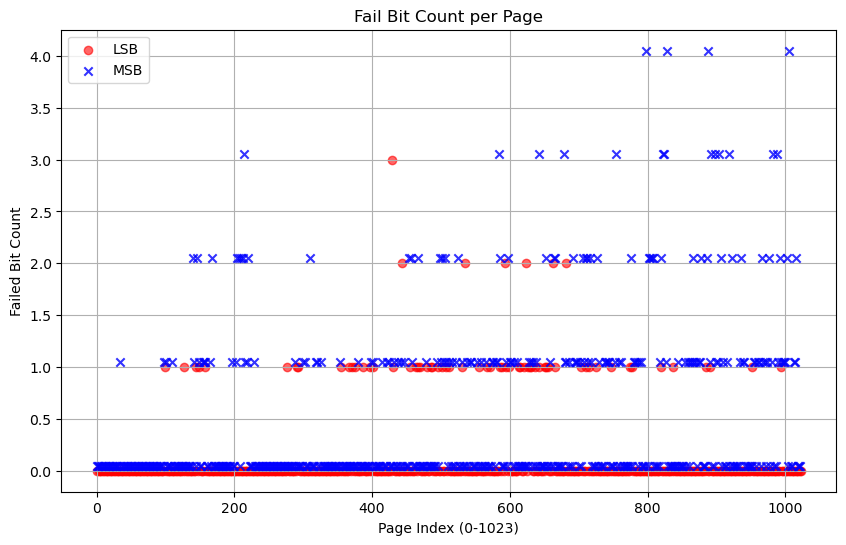

In [60]:
lsb_total_fails = sum(fail_counts[i] for i in range(len(fail_counts)) if i % 2 == 1)
msb_total_fails = sum(fail_counts[i] for i in range(len(fail_counts)) if i % 2 == 0)

print(f"Total fail bits in LSB pages = {lsb_total_fails}")
print(f"Total fail bits in MSB pages = {msb_total_fails}")
plot_fail_bits_scatter(fail_counts)

## TLC CHIP INTERFACE

In [31]:
def nand_read_full_page_tlc(pageno, blockno, PagePerBlock):
    planeno = 0
    pageBytes = 16384
    max_rx_buffer = 4096
    readData = []
    ftdi.purge_buffers()

    addressCycleStream = build_5_cycle_address_tlc(0, pageno, blockno, planeno, 0)
    read_nand_command(addressCycleStream)

    for i in range(0, pageBytes//max_rx_buffer, 1):
        readData += read_nand_page_bytes(max_rx_buffer)
    readData += read_nand_page_bytes(pageBytes%max_rx_buffer)
    
    return readData

In [22]:
linearPageAddress = 0
pagesPerBlock = 2304
NumberOfPlane = 2

pageX, blockX, planeX = decode_page_address(linearPageAddress, pagesPerBlock, NumberOfPlane)
print(f"Address {linearPageAddress} => Page {pageX}, Block {blockX}, Plane {planeX}")

blockEraseAddress = build_3_cycle_address_tlc(pageX, blockX, planeX, 0)

print("3 Address Cycles:")
for i, val in enumerate(blockEraseAddress, start=1):
    print(f" Cycle {i}: 0x{val:02X}  (bin: {val:08b})")

Address 0 => Page 0, Block 0, Plane 0
3 Address Cycles:
 Cycle 1: 0x00  (bin: 00000000)
 Cycle 2: 0x00  (bin: 00000000)
 Cycle 3: 0x00  (bin: 00000000)


In [23]:
erase_nand_block (blockEraseAddress)
status_register_check()

Command 1:  [147, 96, 0, 96]
Command 2:  [147, 160, 0, 0, 146, 0, 0, 146, 0, 0]
Command 4:  [147, 96, 0, 208]
bytearray(b'`')
Status:01100000
Successfully Done!!


In [24]:
nand_read_full_page_tlc(0, 2, 2304)[2]

255

In [214]:
linearPageAddress = 0
pagesPerBlock = 2304
NumberOfPlane = 2

pageX, blockX, planeX = decode_page_address(linearPageAddress, pagesPerBlock, NumberOfPlane)
print(f"Address {linearPageAddress} => Page {pageX}, Block {blockX}, Plane {planeX}")

blockProgramAddress = build_5_cycle_address_tlc(0,pageX, blockX, planeX, 0)

print("5 Address Cycles:")
for i, val in enumerate(blockProgramAddress, start=1):
    print(f" Cycle {i}: 0x{val:02X}  (bin: {val:08b})")

Address 0 => Page 0, Block 0, Plane 0
5 Address Cycles:
 Cycle 1: 0x00  (bin: 00000000)
 Cycle 2: 0x00  (bin: 00000000)
 Cycle 3: 0x00  (bin: 00000000)
 Cycle 4: 0x00  (bin: 00000000)
 Cycle 5: 0x00  (bin: 00000000)


In [30]:
def program_block_zeros(pagePerBlock):
    pageno = 0
    blockno = 0
    planeno = 0
    pageBytes = 16384
    data = createDataStreamZeros(pageBytes)
    for i in range(0, pagePerBlock, 1):
        pageno = i
        blockProgramAddress = build_5_cycle_address_tlc(0, pageno, blockno, planeno, 0)
        program_nand_page (blockProgramAddress, data)
        status_register_check()

In [202]:
program_block_zeros(2304)

bytearray(b'\xff')
Status:11111111
failed, check the status byte
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!

In [215]:
nand_read_full_page_tlc(0, 0, 2304)[0]
nand_read_full_page_tlc(0, 0, 2304)[16383]
nand_read_full_page_tlc(2303, 0, 2304)[0]
nand_read_full_page_tlc(2303, 0, 2304)[16383]

0

In [29]:
from collections import defaultdict

def count_fbc_tlc(start_page, end_page, byte_to_write, fd):
    """
    Count the Failed Bit Count (FBC) from start_page to end_page
    and write the results to the provided file descriptor (fd).
    """
    page_per_block = 2304
    current_block = start_page // page_per_block
    
    fd.write(f"Block = {current_block}\n")
    
    # Dictionary that maps FBC -> list of page indices
    fbc_dict = defaultdict(list)
    
    block_fbc_count = 0

    for page_index in range(start_page, end_page):
        # Read data for the current page (adjust the function as needed)
        page_data = nand_read_full_page_tlc(page_index, current_block, page_per_block)
        
        # Count failing bits in the page
        page_fbc_count = count_failing_bits_in_page(page_data)
        
        # Add the page index to the dictionary for this particular FBC
        fbc_dict[page_fbc_count].append(page_index)

        # Write page-level FBC and raw data to the file
        fd.write(f"Page = {page_index}, FBC = {page_fbc_count}, ")
        fd.write(",".join(str(b) for b in page_data))
        fd.write("\n")
        
        # Accumulate block FBC total (if you need this later)
        block_fbc_count += page_fbc_count

        # Check if we've moved to a new block
        new_block = page_index // page_per_block
        if new_block != current_block:
            # Reset for the new block
            block_fbc_count = page_fbc_count
            current_block = new_block

    # Print summary to console
    print("FBC Process Completed")
    for fbc_value in sorted(fbc_dict.keys()):
        print(f"FBC = {fbc_value}: Pages = {fbc_dict[fbc_value]}")

    # Return the dictionary so the caller can use it
    return dict(fbc_dict)

In [253]:
# Specify your desired start and end pages
start_page = 0
end_page = 2303

# This is just a dummy value for 'byte_to_write'—you can set this as needed
byte_to_write = 0

# Open a file for logging
with open("CHECK_FBC_BITS_TLC_1.txt", "w") as fd:
    # Call the method, passing in your parameters and file descriptor
    fbc_dict_tlc = count_fbc_tlc(start_page, end_page, byte_to_write, fd)

print("Done. Check 'CHECK_FBC_BITS_TLC_1.txt' for results.")

FBC Process Completed
FBC = 0: Pages = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 21, 22, 24, 26, 28, 29, 30, 32, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 62, 65, 68, 71, 74, 77, 80, 83, 86, 89, 92, 95, 98, 101, 104, 107, 110, 113, 116, 119, 122, 125, 128, 131, 134, 137, 140, 143, 146, 149, 151, 152, 155, 158, 161, 163, 164, 167, 170, 173, 175, 176, 178, 179, 182, 185, 188, 190, 191, 193, 194, 197, 200, 203, 206, 209, 212, 215, 218, 221, 224, 227, 230, 233, 235, 236, 239, 241, 242, 245, 248, 251, 254, 257, 259, 260, 263, 266, 269, 272, 275, 278, 281, 284, 287, 290, 293, 296, 299, 302, 305, 308, 311, 314, 317, 320, 323, 326, 329, 332, 335, 337, 338, 341, 344, 347, 349, 350, 353, 356, 359, 362, 365, 368, 370, 371, 374, 377, 380, 383, 386, 389, 391, 392, 395, 398, 401, 404, 407, 410, 413, 415, 416, 419, 422, 425, 428, 431, 434, 437, 440, 443, 446, 449, 452, 455, 458, 461, 463, 464, 467, 470, 473, 476, 479, 482,

In [28]:
import matplotlib.pyplot as plt

def plot_fbc_scatter_single(fbc_dict):
    """
    fbc_dict is a dictionary where:
        key   = FBC (integer)
        value = list of page indices that have this FBC
    Example: {0: [10, 11], 1: [0, 5], 2: [3], ...}
    """
    x_vals = []
    y_vals = []
    
    # Flatten the dictionary into parallel lists for scatter
    for fbc_value, pages in fbc_dict.items():
        for page_index in pages:
            x_vals.append(page_index)
            y_vals.append(fbc_value)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x_vals, y_vals, alpha=0.7, marker='o')
    plt.title("FBC Scatter Plot (BLOCK 0)")
    plt.xlabel("Page Index (0..2303)")
    plt.ylabel("FBC")
    plt.grid(True)

    # Save the figure with high resolution (e.g., 300 dpi)
    plt.savefig("failure bit count_tlc.png", dpi=300, bbox_inches='tight')
    
    plt.show()


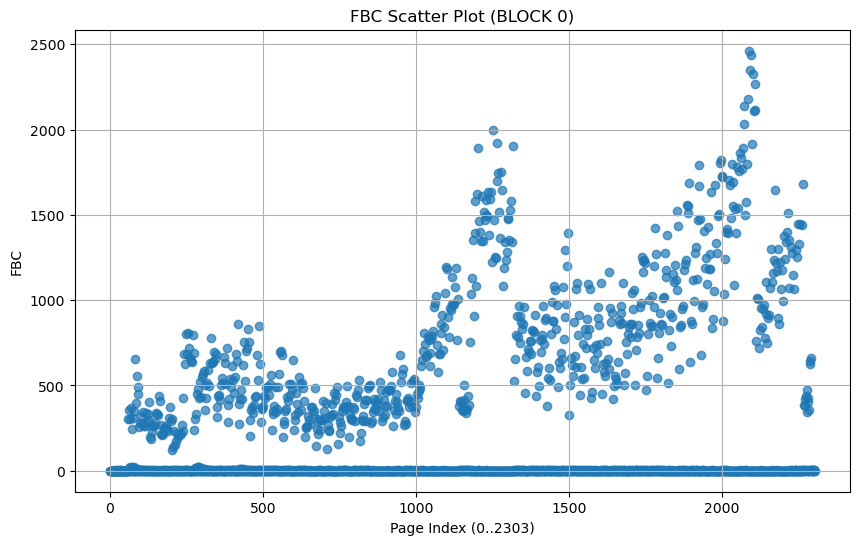

In [259]:
plot_fbc_scatter_single(fbc_dict_tlc)

In [103]:
import pandas as pd
import numpy as np

# Data represented as a list of lists for ease of manipulation
data = [
    [0, None, None, 1, None, None, 2, None, None, 3, None, None],
    [4, None, None, 5, None, None, 6, None, None, 7, None, None],
    [8, None, None, 9, None, None, 10, None, None, 11, None, None],
    [12, 13, None, 14, 15, None, 16, 17, None, 18, 19, None],
    [20, 21, None, 22, 23, None, 24, 25, None, 26, 27, None],
    [28, 29, None, 30, 31, None, 32, 33, None, 34, 35, None],
    [36, 61, 60, 37, 64, 63, 38, 67, 66, 39, 70, 69],
    [40, 73, 72, 41, 76, 75, 42, 79, 78, 43, 82, 81],
    [44, 85, 84, 45, 88, 87, 46, 91, 90, 47, 94, 93],
    [48, 97, 96, 49, 100, 99, 50, 103, 102, 51, 106, 105],
    [52, 109, 108, 53, 112, 111, 54, 115, 114, 55, 118, 117],
    [56, 121, 120, 57, 124, 123, 58, 127, 126, 59, 130, 129],
    [62, 133, 132, 65, 136, 135, 68, 139, 138, 71, 142, 141],
    [74, 145, 144, 77, 148, 147, 80, 151, 150, 83, 154, 153],
    [86, 157, 156, 89, 160, 159, 92, 163, 162, 95, 166, 165],
    [98, 169, 168, 101, 172, 171, 104, 175, 174, 107, 178, 177],
    [110, 181, 180, 113, 184, 183, 116, 187, 186, 119, 190, 189],
    [122, 193, 192, 125, 196, 195, 128, 199, 198, 131, 202, 201],
    [134, 205, 204, 137, 208, 207, 140, 211, 210, 143, 214, 213],
    [146, 217, 216, 149, 220, 219, 152, 223, 222, 155, 226, 225],
    [158, 229, 228, 161, 232, 231, 164, 235, 234, 167, 238, 237],
    [170, 241, 240, 173, 244, 243, 176, 247, 246, 179, 250, 249],
    [182, 253, 252, 185, 256, 255, 188, 259, 258, 191, 262, 261],
    [194, 265, 264, 197, 268, 267, 200, 271, 270, 203, 274, 273],
    [206, 277, 276, 209, 280, 279, 212, 283, 282, 215, 286, 285],
    [218, 289, 288, 221, 292, 291, 224, 295, 294, 227, 298, 297],
    [230, 301, 300, 233, 304, 303, 236, 307, 306, 239, 310, 309],
    [242, 313, 312, 245, 316, 315, 248, 319, 318, 251, 322, 321],
    [254, 325, 324, 257, 328, 327, 260, 331, 330, 263, 334, 333],
    [266, 337, 336, 269, 340, 339, 272, 343, 342, 275, 346, 345],
    [278, 349, 348, 281, 352, 351, 284, 355, 354, 287, 358, 357],
    [290, 361, 360, 293, 364, 363, 296, 367, 366, 299, 370, 369],
    [302, 373, 372, 305, 376, 375, 308, 379, 378, 311, 382, 381],
    [314, 385, 384, 317, 388, 387, 320, 391, 390, 323, 394, 393],
    [326, 397, 396, 329, 400, 399, 332, 403, 402, 335, 406, 405],
    [338, 409, 408, 341, 412, 411, 344, 415, 414, 347, 418, 417],
    [350, 421, 420, 353, 424, 423, 356, 427, 426, 359, 430, 429],
    [362, 433, 432, 365, 436, 435, 368, 439, 438, 371, 442, 441],
    [374, 445, 444, 377, 448, 447, 380, 451, 450, 383, 454, 453],
    [386, 457, 456, 389, 460, 459, 392, 463, 462, 395, 466, 465],
    [398, 469, 468, 401, 472, 471, 404, 475, 474, 407, 478, 477],
    [410, 481, 480, 413, 484, 483, 416, 487, 486, 419, 490, 489],
    [422, 493, 492, 425, 496, 495, 428, 499, 498, 431, 502, 501],
    [434, 505, 504, 437, 508, 507, 440, 511, 510, 443, 514, 513],
    [446, 517, 516, 449, 520, 519, 452, 523, 522, 455, 526, 525],
    [458, 529, 528, 461, 532, 531, 464, 535, 534, 467, 538, 537],
    [470, 541, 540, 473, 544, 543, 476, 547, 546, 479, 550, 549],
    [482, 553, 552, 485, 556, 555, 488, 559, 558, 491, 562, 561],
    [494, 565, 564, 497, 568, 567, 500, 571, 570, 503, 574, 573],
    [506, 577, 576, 509, 580, 579, 512, 583, 582, 515, 586, 585],
    [518, 589, 588, 521, 592, 591, 524, 595, 594, 527, 598, 597],
    [530, 601, 600, 533, 604, 603, 536, 607, 606, 539, 610, 609],
    [542, 613, 612, 545, 616, 615, 548, 619, 618, 551, 622, 621],
    [554, 625, 624, 557, 628, 627, 560, 631, 630, 563, 634, 633],
    [566, 637, 636, 569, 640, 639, 572, 643, 642, 575, 646, 645],
    [578, 649, 648, 581, 652, 651, 584, 655, 654, 587, 658, 657],
    [590, 661, 660, 593, 664, 663, 596, 667, 666, 599, 670, 669],
    [602, 673, 672, 605, 676, 675, 608, 679, 678, 611, 682, 681],
    [614, 685, 684, 617, 688, 687, 620, 691, 690, 623, 694, 693],
    [626, 697, 696, 629, 700, 699, 632, 703, 702, 635, 706, 705],
    [638, 709, 708, 641, 712, 711, 644, 715, 714, 647, 718, 717],
    [650, 721, 720, 653, 724, 723, 656, 727, 726, 659, 730, 729],
    [662, 733, 732, 665, 736, 735, 668, 739, 738, 671, 742, 741],
    [674, 745, 744, 677, 748, 747, 680, 751, 750, 683, 754, 753],
    [686, 757, 756, 689, 760, 759, 692, 763, 762, 695, 766, 765],
    [698, 769, 768, 701, 772, 771, 704, 775, 774, 707, 778, 777],
    [710, 781, 780, 713, 784, 783, 716, 787, 786, 719, 790, 789],
    [722, 793, 792, 725, 796, 795, 728, 799, 798, 731, 802, 801],
    [734, 805, 804, 737, 808, 807, 740, 811, 810, 743, 814, 813],
    [746, 817, 816, 749, 820, 819, 752, 823, 822, 755, 826, 825],
    [758, 829, 828, 761, 832, 831, 764, 835, 834, 767, 838, 837],
    [770, 841, 840, 773, 844, 843, 776, 847, 846, 779, 850, 849],
    [782, 853, 852, 785, 856, 855, 788, 859, 858, 791, 862, 861],
    [794, 865, 864, 797, 868, 867, 800, 871, 870, 803, 874, 873],
    [806, 877, 876, 809, 880, 879, 812, 883, 882, 815, 886, 885],
    [818, 889, 888, 821, 892, 891, 824, 895, 894, 827, 898, 897],
    [830, 901, 900, 833, 904, 903, 836, 907, 906, 839, 910, 909],
    [842, 913, 912, 845, 916, 915, 848, 919, 918, 851, 922, 921],
    [854, 925, 924, 857, 928, 927, 860, 931, 930, 863, 934, 933],
    [866, 937, 936, 869, 940, 939, 872, 943, 942, 875, 946, 945],
    [878, 949, 948, 881, 952, 951, 884, 955, 954, 887, 958, 957],
    [890, 961, 960, 893, 964, 963, 896, 967, 966, 899, 970, 969],
    [902, 973, 972, 905, 976, 975, 908, 979, 978, 911, 982, 981],
    [914, 985, 984, 917, 988, 987, 920, 991, 990, 923, 994, 993],
    [926, 997, 996, 929, 1000, 999, 932, 1003, 1002, 935, 1006, 1005],
    [938, 1009, 1008, 941, 1012, 1011, 944, 1015, 1014, 947, 1018, 1017],
    [950, 1021, 1020, 953, 1024, 1023, 956, 1027, 1026, 959, 1030, 1029],
    [962, 1033, 1032, 965, 1036, 1035, 968, 1039, 1038, 971, 1042, 1041],
    [974, 1045, 1044, 977, 1048, 1047, 980, 1051, 1050, 983, 1054, 1053],
    [986, 1057, 1056, 989, 1060, 1059, 992, 1063, 1062, 995, 1066, 1065],
    [998, 1069, 1068, 1001, 1072, 1071, 1004, 1075, 1074, 1007, 1078, 1077],
    [1010, 1081, 1080, 1013, 1084, 1083, 1016, 1087, 1086, 1019, 1090, 1089],
    [1022, 1093, 1092, 1025, 1096, 1095, 1028, 1099, 1098, 1031, 1102, 1101],
    [1034, 1105, 1104, 1037, 1108, 1107, 1040, 1111, 1110, 1043, 1114, 1113],
    [1046, 1117, 1116, 1049, 1120, 1119, 1052, 1123, 1122, 1055, 1126, 1125],
    [1058, 1129, 1128, 1061, 1132, 1131, 1064, 1135, 1134, 1067, 1138, 1137],
    [1070, 1141, 1140, 1073, 1144, 1143, 1076, 1147, 1146, 1079, 1150, 1149],
    [1082, 1153, 1152, 1085, 1156, 1155, 1088, 1159, 1158, 1091, 1162, 1161],
    [1094, 1165, 1164, 1097, 1168, 1167, 1100, 1171, 1170, 1103, 1174, 1173],
    [1106, 1177, 1176, 1109, 1180, 1179, 1112, 1183, 1182, 1115, 1186, 1185],
    [1118, 1189, 1188, 1121, 1192, 1191, 1124, 1195, 1194, 1127, 1198, 1197],
    [1130, 1201, 1200, 1133, 1204, 1203, 1136, 1207, 1206, 1139, 1210, 1209],
    [1142, 1213, 1212, 1145, 1216, 1215, 1148, 1219, 1218, 1151, 1222, 1221],
    [1154, 1225, 1224, 1157, 1228, 1227, 1160, 1231, 1230, 1163, 1234, 1233],
    [1166, 1237, 1236, 1169, 1240, 1239, 1172, 1243, 1242, 1175, 1246, 1245],
    [1178, 1249, 1248, 1181, 1252, 1251, 1184, 1255, 1254, 1187, 1258, 1257],
    [1190, 1261, 1260, 1193, 1264, 1263, 1196, 1267, 1266, 1199, 1270, 1269],
    [1202, 1273, 1272, 1205, 1276, 1275, 1208, 1279, 1278, 1211, 1282, 1281],
    [1214, 1285, 1284, 1217, 1288, 1287, 1220, 1291, 1290, 1223, 1294, 1293],
    [1226, 1297, 1296, 1229, 1300, 1299, 1232, 1303, 1302, 1235, 1306, 1305],
    [1238, 1309, 1308, 1241, 1312, 1311, 1244, 1315, 1314, 1247, 1318, 1317],
    [1250, 1321, 1320, 1253, 1324, 1323, 1256, 1327, 1326, 1259, 1330, 1329],
    [1262, 1333, 1332, 1265, 1336, 1335, 1268, 1339, 1338, 1271, 1342, 1341],
    [1274, 1345, 1344, 1277, 1348, 1347, 1280, 1351, 1350, 1283, 1354, 1353],
    [1286, 1357, 1356, 1289, 1360, 1359, 1292, 1363, 1362, 1295, 1366, 1365],
    [1298, 1369, 1368, 1301, 1372, 1371, 1304, 1375, 1374, 1307, 1378, 1377],
    [1310, 1381, 1380, 1313, 1384, 1383, 1316, 1387, 1386, 1319, 1390, 1389],
    [1322, 1393, 1392, 1325, 1396, 1395, 1328, 1399, 1398, 1331, 1402, 1401],
    [1334, 1405, 1404, 1337, 1408, 1407, 1340, 1411, 1410, 1343, 1414, 1413],
    [1346, 1417, 1416, 1349, 1420, 1419, 1352, 1423, 1422, 1355, 1426, 1425],
    [1358, 1429, 1428, 1361, 1432, 1431, 1364, 1435, 1434, 1367, 1438, 1437],
    [1370, 1441, 1440, 1373, 1444, 1443, 1376, 1447, 1446, 1379, 1450, 1449],
    [1382, 1453, 1452, 1385, 1456, 1455, 1388, 1459, 1458, 1391, 1462, 1461],
    [1394, 1465, 1464, 1397, 1468, 1467, 1400, 1471, 1470, 1403, 1474, 1473],
    [1406, 1477, 1476, 1409, 1480, 1479, 1412, 1483, 1482, 1415, 1486, 1485],
    [1418, 1489, 1488, 1421, 1492, 1491, 1424, 1495, 1494, 1427, 1498, 1497],
    [1430, 1501, 1500, 1433, 1504, 1503, 1436, 1507, 1506, 1439, 1510, 1509],
    [1442, 1513, 1512, 1445, 1516, 1515, 1448, 1519, 1518, 1451, 1522, 1521],
    [1454, 1525, 1524, 1457, 1528, 1527, 1460, 1531, 1530, 1463, 1534, 1533],
    [1466, 1537, 1536, 1469, 1540, 1539, 1472, 1543, 1542, 1475, 1546, 1545],
    [1478, 1549, 1548, 1481, 1552, 1551, 1484, 1555, 1554, 1487, 1558, 1557],
    [1490, 1561, 1560, 1493, 1564, 1563, 1496, 1567, 1566, 1499, 1570, 1569],
    [1502, 1573, 1572, 1505, 1576, 1575, 1508, 1579, 1578, 1511, 1582, 1581],
    [1514, 1585, 1584, 1517, 1588, 1587, 1520, 1591, 1590, 1523, 1594, 1593],
    [1526, 1597, 1596, 1529, 1600, 1599, 1532, 1603, 1602, 1535, 1606, 1605],
    [1538, 1609, 1608, 1541, 1612, 1611, 1544, 1615, 1614, 1547, 1618, 1617],
    [1550, 1621, 1620, 1553, 1624, 1623, 1556, 1627, 1626, 1559, 1630, 1629],
    [1562, 1633, 1632, 1565, 1636, 1635, 1568, 1639, 1638, 1571, 1642, 1641],
    [1574, 1645, 1644, 1577, 1648, 1647, 1580, 1651, 1650, 1583, 1654, 1653],
    [1586, 1657, 1656, 1589, 1660, 1659, 1592, 1663, 1662, 1595, 1666, 1665],
    [1598, 1669, 1668, 1601, 1672, 1671, 1604, 1675, 1674, 1607, 1678, 1677],
    [1610, 1681, 1680, 1613, 1684, 1683, 1616, 1687, 1686, 1619, 1690, 1689],
    [1622, 1693, 1692, 1625, 1696, 1695, 1628, 1699, 1698, 1631, 1702, 1701],
    [1634, 1705, 1704, 1637, 1708, 1707, 1640, 1711, 1710, 1643, 1714, 1713],
    [1646, 1717, 1716, 1649, 1720, 1719, 1652, 1723, 1722, 1655, 1726, 1725],
    [1658, 1729, 1728, 1661, 1732, 1731, 1664, 1735, 1734, 1667, 1738, 1737],
    [1670, 1741, 1740, 1673, 1744, 1743, 1676, 1747, 1746, 1679, 1750, 1749],
    [1682, 1753, 1752, 1685, 1756, 1755, 1688, 1759, 1758, 1691, 1762, 1761],
    [1694, 1765, 1764, 1697, 1768, 1767, 1700, 1771, 1770, 1703, 1774, 1773],
    [1706, 1777, 1776, 1709, 1780, 1779, 1712, 1783, 1782, 1715, 1786, 1785],
    [1718, 1789, 1788, 1721, 1792, 1791, 1724, 1795, 1794, 1727, 1798, 1797],
    [1730, 1801, 1800, 1733, 1804, 1803, 1736, 1807, 1806, 1739, 1810, 1809],
    [1742, 1813, 1812, 1745, 1816, 1815, 1748, 1819, 1818, 1751, 1822, 1821],
    [1754, 1825, 1824, 1757, 1828, 1827, 1760, 1831, 1830, 1763, 1834, 1833],
    [1766, 1837, 1836, 1769, 1840, 1839, 1772, 1843, 1842, 1775, 1846, 1845],
    [1778, 1849, 1848, 1781, 1852, 1851, 1784, 1855, 1854, 1787, 1858, 1857],
    [1790, 1861, 1860, 1793, 1864, 1863, 1796, 1867, 1866, 1799, 1870, 1869],
    [1802, 1873, 1872, 1805, 1876, 1875, 1808, 1879, 1878, 1811, 1882, 1881],
    [1814, 1885, 1884, 1817, 1888, 1887, 1820, 1891, 1890, 1823, 1894, 1893],
    [1826, 1897, 1896, 1829, 1900, 1899, 1832, 1903, 1902, 1835, 1906, 1905],
    [1838, 1909, 1908, 1841, 1912, 1911, 1844, 1915, 1914, 1847, 1918, 1917],
    [1850, 1921, 1920, 1853, 1924, 1923, 1856, 1927, 1926, 1859, 1930, 1929],
    [1862, 1933, 1932, 1865, 1936, 1935, 1868, 1939, 1938, 1871, 1942, 1941],
    [1874, 1945, 1944, 1877, 1948, 1947, 1880, 1951, 1950, 1883, 1954, 1953],
    [1886, 1957, 1956, 1889, 1960, 1959, 1892, 1963, 1962, 1895, 1966, 1965],
    [1898, 1969, 1968, 1901, 1972, 1971, 1904, 1975, 1974, 1907, 1978, 1977],
    [1910, 1981, 1980, 1913, 1984, 1983, 1916, 1987, 1986, 1919, 1990, 1989],
    [1922, 1993, 1992, 1925, 1996, 1995, 1928, 1999, 1998, 1931, 2002, 2001],
    [1934, 2005, 2004, 1937, 2008, 2007, 1940, 2011, 2010, 1943, 2014, 2013],
    [1946, 2017, 2016, 1949, 2020, 2019, 1952, 2023, 2022, 1955, 2026, 2025],
    [1958, 2029, 2028, 1961, 2032, 2031, 1964, 2035, 2034, 1967, 2038, 2037],
    [1970, 2041, 2040, 1973, 2044, 2043, 1976, 2047, 2046, 1979, 2050, 2049],
    [1982, 2053, 2052, 1985, 2056, 2055, 1988, 2059, 2058, 1991, 2062, 2061],
    [1994, 2065, 2064, 1997, 2068, 2067, 2000, 2071, 2070, 2003, 2074, 2073],
    [2006, 2077, 2076, 2009, 2080, 2079, 2012, 2083, 2082, 2015, 2086, 2085],
    [2018, 2089, 2088, 2021, 2092, 2091, 2024, 2095, 2094, 2027, 2098, 2097],
    [2030, 2101, 2100, 2033, 2104, 2103, 2036, 2107, 2106, 2039, 2110, 2109],
    [2042, 2113, 2112, 2045, 2116, 2115, 2048, 2119, 2118, 2051, 2122, 2121],
    [2054, 2125, 2124, 2057, 2128, 2127, 2060, 2131, 2130, 2063, 2134, 2133],
    [2066, 2137, 2136, 2069, 2140, 2139, 2072, 2143, 2142, 2075, 2146, 2145],
    [2078, 2149, 2148, 2081, 2152, 2151, 2084, 2155, 2154, 2087, 2158, 2157],
    [2090, 2161, 2160, 2093, 2164, 2163, 2096, 2167, 2166, 2099, 2170, 2169],
    [2102, 2173, 2172, 2105, 2176, 2175, 2108, 2179, 2178, 2111, 2182, 2181],
    [2114, 2185, 2184, 2117, 2188, 2187, 2120, 2191, 2190, 2123, 2194, 2193],
    [2126, 2197, 2196, 2129, 2200, 2199, 2132, 2203, 2202, 2135, 2206, 2205],
    [2138, 2209, 2208, 2141, 2212, 2211, 2144, 2215, 2214, 2147, 2218, 2217],
    [2150, 2221, 2220, 2153, 2225, 2224, 2156, 2229, 2228, 2159, 2233, 2232],
    [2162, 2237, 2236, 2165, 2241, 2240, 2168, 2245, 2244, 2171, 2249, 2248],
    [2174, 2253, 2252, 2177, 2257, 2256, 2180, 2261, 2260, 2183, 2265, 2264],
    [2186, 2269, 2268, 2189, 2271, 2270, 2192, 2273, 2272, 2195, 2275, 2274],
    [2198, 2277, 2276, 2201, 2279, 2278, 2204, 2281, 2280, 2207, 2283, 2282],
    [2210, 2285, 2284, 2213, 2287, 2286, 2216, 2289, 2288, 2219, 2291, 2290],
    [2222, 2223, None, 2226, 2227, None, 2230, 2231, None, 2234, 2235, None],
    [2238, 2239, None, 2242, 2243, None, 2246, 2247, None, 2250, 2251, None],
    [2254, 2255, None, 2258, 2259, None, 2262, 2263, None, 2266, 2267, None],
    [2292, None, None, 2293, None, None, 2294, None, None, 2295, None, None],
    [2296, None, None, 2297, None, None, 2298, None, None, 2299, None, None],
    [2300, None, None, 2301, None, None, 2302, None, None, 2303, None, None],
]


In [25]:
# Column names for clarity
columns = ['LP', 'UP', 'XP'] * 4

# Create the DataFrame
df = pd.DataFrame(data, columns=columns)

# Separate into LP, UP, XP arrays
lp_array = df[['LP']].to_numpy().flatten()
up_array = df[['UP']].to_numpy().flatten()
xp_array = df[['XP']].to_numpy().flatten()

# Display the arrays
lp_array, up_array, xp_array

# Converting arrays to integers where possible and handling NaN separately
lp_array = [int(x) if not np.isnan(x) else None for x in lp_array]
up_array = [int(x) if not np.isnan(x) else None for x in up_array]
xp_array = [int(x) if not np.isnan(x) else None for x in xp_array]

# Display the updated arrays
lp_array, up_array, xp_array

print(lp_array)
print(up_array)
print(xp_array)

print(len(lp_array) + len(up_array) + len(xp_array))


NameError: name 'pd' is not defined

In [27]:
import matplotlib.pyplot as plt

def plot_fbc_shared_pages(fbc_dict, lp_array, up_array, xp_array):
    """
    fbc_dict: Dictionary returned by count_fbc, mapping FBC -> list of page indices
    lp_array: List of page indices (lower pages)
    up_array: List of page indices (upper pages)
    xp_array: List of page indices (extra pages)
    
    This function creates a scatter plot of page indices (x-axis)
    vs. FBC (y-axis), color-coded by whether the page is in
    lp_array (red), up_array (blue), or xp_array (green).
    """

    # Prepare containers for each category
    lp_points = []  # will hold (page_index, FBC)
    up_points = []
    xp_points = []

    # Loop over FBC -> pages
    for fbc_value, pages in fbc_dict.items():
        for page_index in pages:
            # Check which array this page belongs to
            if page_index in lp_array:
                lp_points.append((page_index, fbc_value))
            elif page_index in up_array:
                up_points.append((page_index, fbc_value))
            elif page_index in xp_array:
                xp_points.append((page_index, fbc_value))
            else:
                # If a page is not in any of the three arrays,
                # you could either skip it or plot it in another color.
                pass

    # Convert each list of tuples into separate x and y lists
    def unpack_points(points_list):
        if points_list:
            x_vals, y_vals = zip(*points_list)
        else:
            x_vals, y_vals = [], []
        return x_vals, y_vals

    x_lp, y_lp = unpack_points(lp_points)
    x_up, y_up = unpack_points(up_points)
    y_up_jittered = [y + 25 for y in y_up]
    x_xp, y_xp = unpack_points(xp_points)

    # Plot
    plt.figure(figsize=(20, 8))

    # LP in red
    plt.scatter(x_lp, y_lp, c="red", marker="o", alpha=0.7, label="LP (Lower Pages)")
    # UP in blue
    plt.scatter(x_up, y_up_jittered, c="blue", marker="^", alpha=0.7, label="UP (Upper Pages)")
    # XP in green
    plt.scatter(x_xp, y_xp, c="green", marker="s", alpha=0.7, label="XP (Extra Pages)")

    plt.title("FBC Scatter Plot by Shared Pages")
    plt.xlabel("Page Index (0..2303)")
    plt.ylabel("FBC")
    plt.grid(True)
    plt.legend()
    # Save the figure with high resolution (e.g., 300 dpi)
    plt.savefig("failure bit count_tlc.png", dpi=300, bbox_inches='tight')
    
    plt.show()


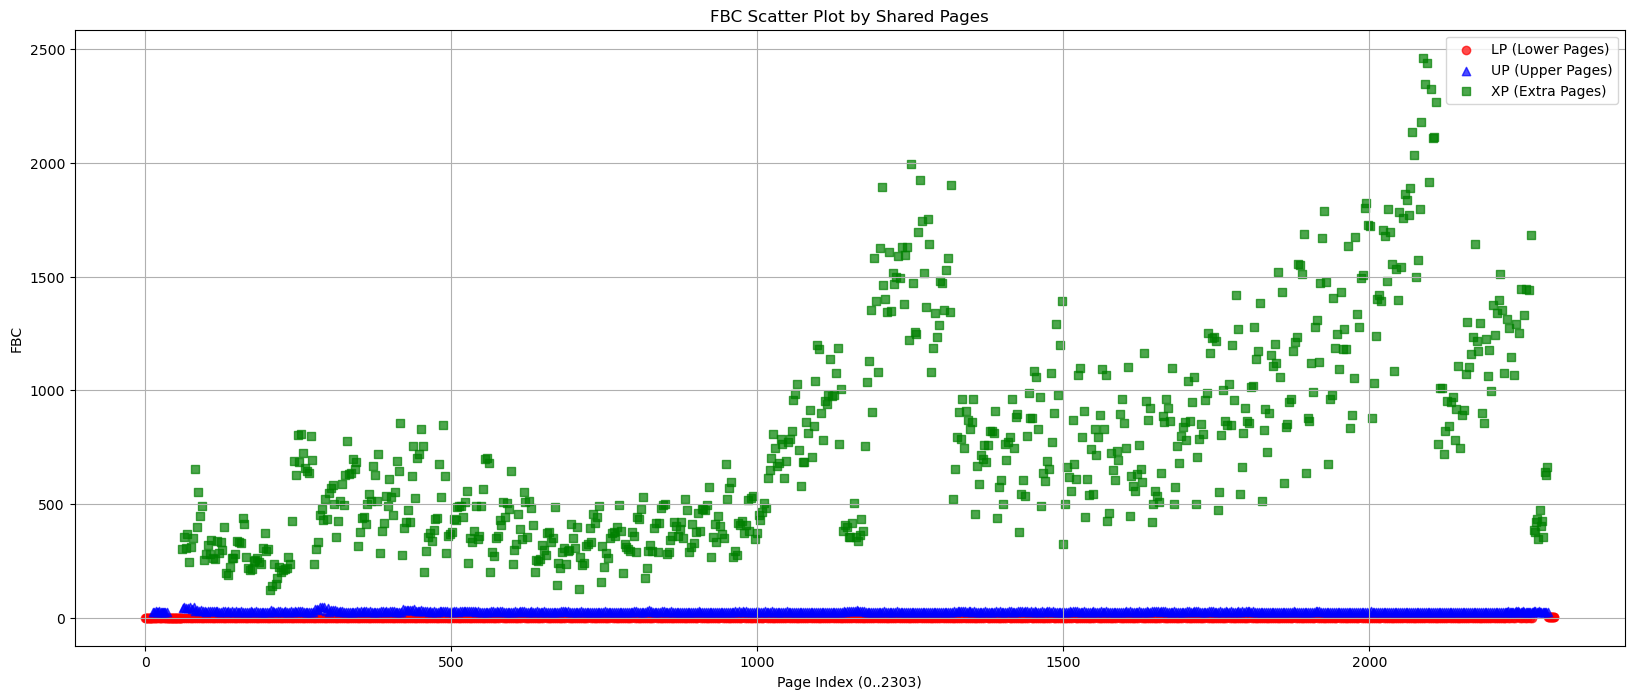

In [ ]:
plot_fbc_shared_pages(fbc_dict_tlc, lp_array, up_array, xp_array)

## FAILED BIT COUNT: TLC PROGRAMMED WITH RANDOM NUMBERS

In [40]:
create_nand_random_file("nand_random_data_tlc.txt", num_pages=2304, page_size=16384)

In [41]:
randomData = read_random_values("nand_random_data_tlc.txt")

print (randomData[0][20])
print (len(randomData[2303]))

23
16384


In [49]:
def program_block_with_random_data(filename):
    # Read all random data from the file into a list of pages
    all_pages_data = read_random_values(filename)
    
    pagePerBlock = 2304
    blockno = 0
    planeno = 0
    pageBytes = 16384  # Make sure this matches the length of data in each page
    
    # Safety check: ensure we have at least 1024 pages worth of data
    if len(all_pages_data) < pagePerBlock:
        raise ValueError(
            f"Not enough pages in file! "
            f"Expected at least {pagePerBlock}, got {len(all_pages_data)}"
        )

    # Iterate through each page in the block
    for pageno in range(pagePerBlock):
        # Build the address for page pageno in blockno
        addressCycleStream = build_5_cycle_address_tlc(0, pageno, blockno, planeno, 0)
        
        # Get the data for this page
        data = all_pages_data[pageno]
        
        # Check that the page data matches pageBytes in length
        if len(data) != pageBytes:
            raise ValueError(
                f"Page {pageno} has {len(data)} bytes, expected {pageBytes} bytes."
            )
        
        # Program the page
        program_nand_page(addressCycleStream, data)
        # After programming all pages in the block, check status
        status_register_check()


In [43]:
program_block_with_random_data("nand_random_data_tlc.txt")

bytearray(b'\xff')
Status:11111111
failed, check the status byte
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!
bytearray(b'`')
Status:01100000
Successfully Done!!

In [44]:
programData = nand_read_full_page_tlc(0, 0, 2304)
print(programData[20])
len(programData)

23


16384

In [50]:
def measure_fail_bit_counts(filename, blockno, pagePerBlock):
    """
    Read back each page in a block and compare against the original data from 'filename'.
    Return a list of fail-bit counts for each page.
    """
    # Load the original random data from file
    all_pages_data = read_random_values(filename)
    page_fail_bit_counts = []

    for pageno in range(pagePerBlock):
        # 1. Read back the programmed page
        programData = nand_read_full_page_tlc(pageno, blockno, 2304)
        
        # 2. Retrieve the original data for comparison
        written_data = all_pages_data[pageno]
        
        # 3. Count fail bits
        fail_bits = count_fail_bits(written_data, programData)
        page_fail_bit_counts.append(fail_bits)
    
    return page_fail_bit_counts

In [51]:
# 2. Measure fail-bit counts for each page in the block
fail_counts = measure_fail_bit_counts("nand_random_data_tlc.txt", blockno=0, pagePerBlock=2304)

# 3. Print or store the results
#for page_idx, fbits in enumerate(fail_counts):
    #print(f"Page {page_idx}: {fbits} fail bits")

# Or calculate a total for the block if you wish
total_fail_bits = sum(fail_counts)
print(f"Total fail bits across all pages in block: {total_fail_bits}")

Total fail bits across all pages in block: 27274


In [ ]:
print(type(fail_counts))
print(fail_counts)
print(sum(fail_counts))

<class 'list'>
[1, 2, 0, 1, 2, 1, 2, 0, 0, 1, 4, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 20, 9, 18, 20, 27, 14, 27, 14, 11, 21, 14, 18, 10, 6, 14, 13, 13, 14, 10, 14, 11, 12, 17, 9, 21, 24, 4, 21, 36, 3, 19, 42, 6, 22, 40, 2, 19, 49, 5, 26, 41, 7, 30, 32, 4, 17, 58, 5, 25, 40, 4, 23, 48, 5, 26, 44, 4, 42, 41, 6, 13, 12, 2, 11, 16, 7, 14, 14, 2, 25, 21, 3, 28, 20, 6, 11, 21, 3, 20, 16, 2, 13, 22, 4, 22, 16, 2, 23, 24, 4, 23, 23, 2, 18, 30, 3, 19, 8, 4, 12, 14, 2, 20, 10, 3, 22, 10, 8, 16, 11, 2, 15, 2, 5, 20, 12, 2, 13, 17, 4, 9, 8, 0, 21, 16, 4, 18, 15, 6, 17, 11, 3, 6, 5, 13, 7, 7, 10, 12, 9, 4, 7, 6, 8, 9, 5, 7, 13, 7, 3, 10, 5, 9, 16, 11, 6, 5, 14, 5, 7, 10, 7, 10, 11, 4, 8, 7, 6, 9, 6, 11, 8, 10, 9, 5, 6, 10, 7, 7, 6, 15, 10, 11, 7, 9, 9, 6, 6, 7, 6, 10, 4, 4, 10, 14, 9, 13, 11, 16, 11, 11, 9, 12, 6, 16, 7, 2, 33, 18, 3, 22, 17, 5, 19, 15, 2, 20, 9, 2, 23, 15, 4, 21, 18, 3, 25, 14, 6, 23, 18, 5, 27, 19, 0, 18, 18, 1, 20, 13, 3, 14, 20, 5, 16, 12, 

In [ ]:
# Specify your desired start and end pages
start_page = 0
end_page = 2303

# This is just a dummy value for 'byte_to_write'—you can set this as needed
byte_to_write = 0

# Open a file for logging
with open("CHECK_FBC_BITS_TLC_1.txt", "w") as fd:
    # Call the method, passing in your parameters and file descriptor
    fbc_dict_tlc = count_fbc_tlc(start_page, end_page, byte_to_write, fd)

print("Done. Check 'CHECK_FBC_BITS_TLC_1.txt' for results.")

In [113]:
import matplotlib.pyplot as plt

def plot_fail_bits_scatter(fail_counts):
    """
    Given a list of fail bit counts (index = page index),
    create a scatter plot separating LSB from MSB.
    """
    # Separate pages
    failed_pages = []

    for page_idx in range(len(fail_counts)):
        failed_pages.append((page_idx, fail_counts[page_idx]))


    # Unzip the page index (x) and fail-bit count (y) for plotting
    x_fail, y_fail = zip(*failed_pages) if failed_pages else ([], [])
    
    # Create the scatter plot
    plt.figure(figsize=(20, 8))
    plt.scatter(x_fail, y_fail, c="blue", marker="x", alpha=0.6, zorder=1)


    plt.title("Fail Bit Count per Page")
    plt.xlabel("Page Index (0-1023)")
    plt.ylabel("Failed Bit Count")
    plt.grid(True)
    
    # Save the figure with high resolution (e.g., 300 dpi)
    plt.savefig("failure bit count_random_tlc.png", dpi=300, bbox_inches='tight')
    
    plt.show()

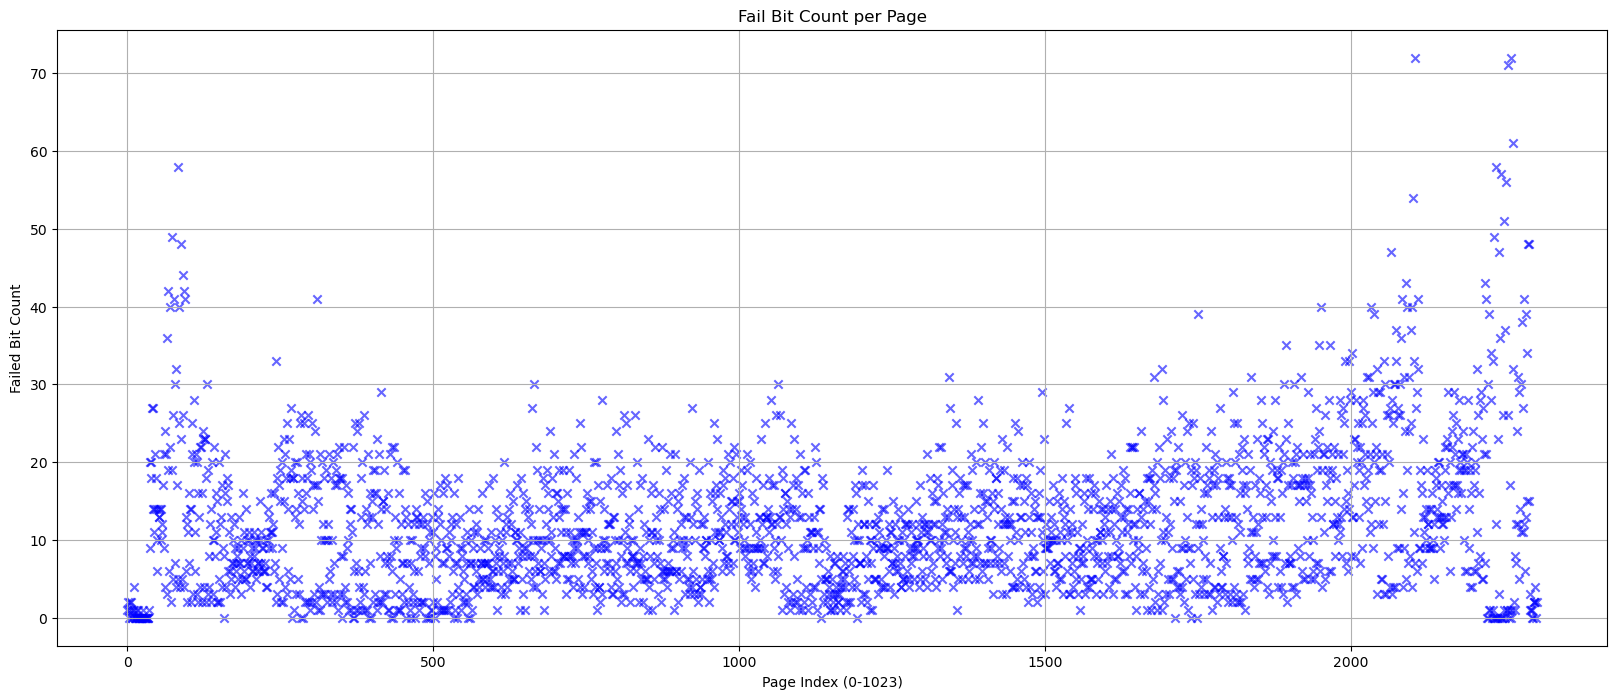

In [117]:
plot_fail_bits_scatter(fail_counts)

In [125]:
import matplotlib.pyplot as plt

def plot_fail_counts_by_page_type(fail_counts, lp_array, up_array, xp_array):
    """
    Create a scatter plot using fail_counts (y-axis) vs. page index (x-axis),
    color-coded by which array (LP, UP, XP) the page belongs to.
    """

    lp_x = []
    lp_y = []
    for page_idx in lp_array:
        if page_idx is None:
            # Optionally skip or raise an error; here we skip:
            continue
        lp_x.append(page_idx)
        lp_y.append(fail_counts[page_idx])

    up_x = []
    up_y = []
    for page_idx in up_array:
        if page_idx is None:
            continue
        up_x.append(page_idx)
        up_y.append(fail_counts[page_idx])

    xp_x = []
    xp_y = []
    for page_idx in xp_array:
        if page_idx is None:
            continue
        xp_x.append(page_idx)
        xp_y.append(fail_counts[page_idx])

    plt.figure(figsize=(20, 8))

    # Lower Pages: red circles
    plt.scatter(lp_x, lp_y, c="red", marker="o", label="Lower Pages (LP)", alpha=0.7)

    # Upper Pages: blue triangles
    plt.scatter(up_x, up_y, c="blue", marker="^", label="Upper Pages (UP)", alpha=0.7)

    # Extra Pages: green squares
    plt.scatter(xp_x, xp_y, c="green", marker="s", label="Extra Pages (XP)", alpha=0.7)

    plt.title("Fail Bit Counts by Page Type")
    plt.xlabel("Page Index")
    plt.ylabel("Fail Bit Count")
    plt.grid(True)
    plt.legend()
    plt.savefig("failure bit count_random_tlc_sharedPages.png", dpi=300, bbox_inches='tight')
    plt.show()


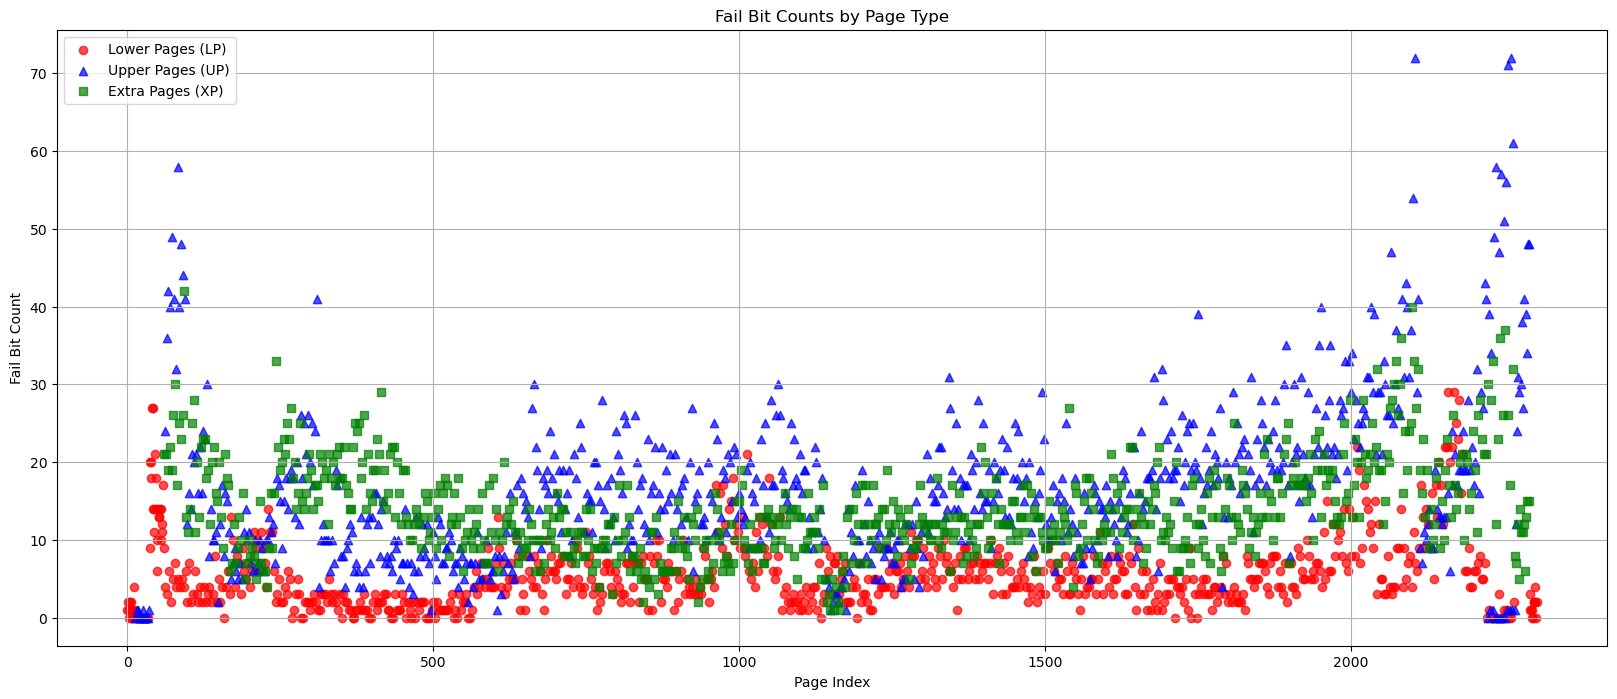

In [126]:
plot_fail_counts_by_page_type(fail_counts, lp_array, up_array, xp_array)

In [ ]:
# LP, UP, XP
layers_66_sb0 = [[(0, None, None)], [(12, 13, None)], [(36, 61, 60)], [(48, 97, 96)], [(62, 133, 132)], [(98, 169, 168)], [(134, 205, 204)], [(170, 241, 240)], [(206, 277, 276)], [(242, 313, 312)], [(278, 349, 348)], [(314, 385, 384)], [(350, 421, 420)], [(386, 457, 456)], [(422, 493, 492)], [(458, 529, 528)], [(494, 565, 564)], [(530, 601, 600)], [(566, 637, 636)], [(602, 673, 672)], [(638, 709, 708)], [(674, 745, 744)], [(710, 781, 780)], [(746, 817, 816)], [(782, 853, 852)], [(818, 889, 888)], [(854, 925, 924)], [(890, 961, 960)], [(926, 997, 996)], [(962, 1033, 1032)], [(998, 1069, 1068)], [(1034, 1105, 1104)], [(1070, 1141, 1140)], [(1106, 1177, 1176)], [(1142, 1213, 1212)], [(1178, 1249, 1248)], [(1214, 1285, 1284)], [(1250, 1321, 1320)], [(1286, 1357, 1356)], [(1322, 1393, 1392)], [(1358, 1429, 1428)], [(1394, 1465, 1464)], [(1430, 1501, 1500)], [(1466, 1537, 1536)], [(1502, 1573, 1572)], [(1538, 1609, 1608)], [(1574, 1645, 1644)], [(1610, 1681, 1680)], [(1646, 1717, 1716)], [(1682, 1753, 1752)], [(1718, 1789, 1788)], [(1754, 1825, 1824)], [(1790, 1861, 1860)], [(1826, 1897, 1896)], [(1862, 1933, 1932)], [(1898, 1969, 1968)], [(1934, 2005, 2004)], [(1970, 2041, 2040)], [(2006, 2077, 2076)], [(2042, 2113, 2112)], [(2078, 2149, 2148)], [(2114, 2185, 2184)], [(2150, 2221, 2220)], [(2186, 2269, 2268)], [(2222, 2223, None)], [(2292, None, None)]]
layers_66_sb1 = [[(1, None, None)], [(14, 15, None)], [(37, 64, 63)], [(49, 100, 99)], [(65, 136, 135)], [(101, 172, 171)], [(137, 208, 207)], [(173, 244, 243)], [(209, 280, 279)], [(245, 316, 315)], [(281, 352, 351)], [(317, 388, 387)], [(353, 424, 423)], [(389, 460, 459)], [(425, 496, 495)], [(461, 532, 531)], [(497, 568, 567)], [(533, 604, 603)], [(569, 640, 639)], [(605, 676, 675)], [(641, 712, 711)], [(677, 748, 747)], [(713, 784, 783)], [(749, 820, 819)], [(785, 856, 855)], [(821, 892, 891)], [(857, 928, 927)], [(893, 964, 963)], [(929, 1000, 999)], [(965, 1036, 1035)], [(1001, 1072, 1071)], [(1037, 1108, 1107)], [(1073, 1144, 1143)], [(1109, 1180, 1179)], [(1145, 1216, 1215)], [(1181, 1252, 1251)], [(1217, 1288, 1287)], [(1253, 1324, 1323)], [(1289, 1360, 1359)], [(1325, 1396, 1395)], [(1349, 1420, 1419)], [(1397, 1468, 1467)], [(1433, 1504, 1503)], [(1469, 1540, 1539)], [(1505, 1576, 1575)], [(1541, 1612, 1611)], [(1577, 1648, 1647)], [(1613, 1684, 1683)], [(1649, 1720, 1719)], [(1685, 1756, 1755)], [(1721, 1792, 1791)], [(1757, 1828, 1827)], [(1793, 1864, 1863)], [(1829, 1900, 1899)], [(1865, 1936, 1935)], [(1901, 1972, 1971)], [(1937, 2008, 2007)], [(1973, 2044, 2043)], [(2009, 2080, 2079)], [(2045, 2116, 2115)], [(2081, 2152, 2151)], [(2117, 2188, 2187)], [(2153, 2225, 2224)], [(2189, 2271, 2270)], [(2226, 2227, None)], [(2293, None, None)]]
layers_66_sb2 = [[(2, None, None)], [(16, 17, None)], [(38, 67, 66)], [(50, 103, 102)], [(68, 139, 138)], [(104, 175, 174)], [(140, 211, 210)], [(176, 247, 246)], [(212, 283, 282)], [(248, 319, 318)], [(284, 355, 354)], [(320, 391, 390)], [(356, 427, 426)], [(392, 463, 462)], [(428, 499, 498)], [(464, 535, 534)], [(500, 571, 570)], [(536, 607, 606)], [(572, 643, 642)], [(608, 679, 678)], [(644, 715, 714)], [(680, 751, 750)], [(716, 787, 786)], [(752, 823, 822)], [(788, 859, 858)], [(824, 895, 894)], [(860, 931, 930)], [(896, 967, 966)], [(932, 1003, 1002)], [(968, 1039, 1038)], [(1004, 1075, 1074)], [(1040, 1111, 1110)], [(1076, 1147, 1146)], [(1112, 1183, 1182)], [(1148, 1219, 1218)], [(1184, 1255, 1254)], [(1220, 1291, 1290)], [(1256, 1327, 1326)], [(1292, 1363, 1362)], [(1328, 1399, 1398)], [(1364, 1435, 1434)], [(1400, 1471, 1470)], [(1436, 1507, 1506)], [(1472, 1543, 1542)], [(1508, 1579, 1578)], [(1544, 1615, 1614)], [(1580, 1651, 1650)], [(1616, 1687, 1686)], [(1652, 1723, 1722)], [(1688, 1759, 1758)], [(1724, 1795, 1794)], [(1760, 1831, 1830)], [(1796, 1867, 1866)], [(1832, 1903, 1902)], [(1868, 1939, 1938)], [(1904, 1975, 1974)], [(1940, 2011, 2010)], [(1976, 2047, 2046)], [(2012, 2083, 2082)], [(2048, 2119, 2118)], [(2084, 2155, 2154)], [(2120, 2191, 2190)], [(2156, 2229, 2228)], [(2192, 2273, 2272)], [(2230, 2231, None)], [(2294, None, None)]]


In [88]:
import matplotlib.pyplot as plt

def plot_layer_fbc_scatter(fail_counts, layers_66):
    """
    Scatter plot of Fail Bit Counts vs. Layer index.
    
    - x-axis = layer index (0..65)
    - y-axis = fail bit count
    - 3 points per layer in different colors for LP, XP, UP.
    """

    lp_points = []
    xp_points = []
    up_points = []

    # Iterate over all 66 layers
    for layer_index in range(len(layers_66)):
        # layers_66[layer_index] is a single-element list of the form: [(LP, XP, UP)]
        (lp, xp, up) = layers_66[layer_index][0]  # Extract the tuple

        # If LP is not None, create a point (layer_index, fail_counts[LP])
        if lp is not None:
            lp_points.append((layer_index, fail_counts[lp]))

        # If XP is not None, similarly
        if xp is not None:
            xp_points.append((layer_index, fail_counts[xp]))

        # If UP is not None
        if up is not None:
            up_points.append((layer_index, fail_counts[up]))

    # Unpack each list of (x, y) into separate lists for matplotlib
    lp_x, lp_y = zip(*lp_points) if lp_points else ([], [])
    xp_x, xp_y = zip(*xp_points) if xp_points else ([], [])
    up_x, up_y = zip(*up_points) if up_points else ([], [])

    # 2. Plot
    plt.figure(figsize=(20, 8))
    plt.scatter(lp_x, lp_y, color="red", marker="o", label="LP", alpha=0.8)
    plt.scatter(xp_x, xp_y, color="green", marker="^", label="XP", alpha=0.8)
    plt.scatter(up_x, up_y, color="blue", marker="s", label="UP", alpha=0.8)

    plt.title("Fail Bit Counts by Layer For SubBlock0")
    plt.xlabel("Layer Index (0..65)")
    plt.ylabel("Fail Bit Count")
    plt.grid(True)
    plt.legend()
    plt.savefig("failure bit count_random_tlc_per_layer_sub0.png", dpi=300, bbox_inches='tight')

    plt.show()



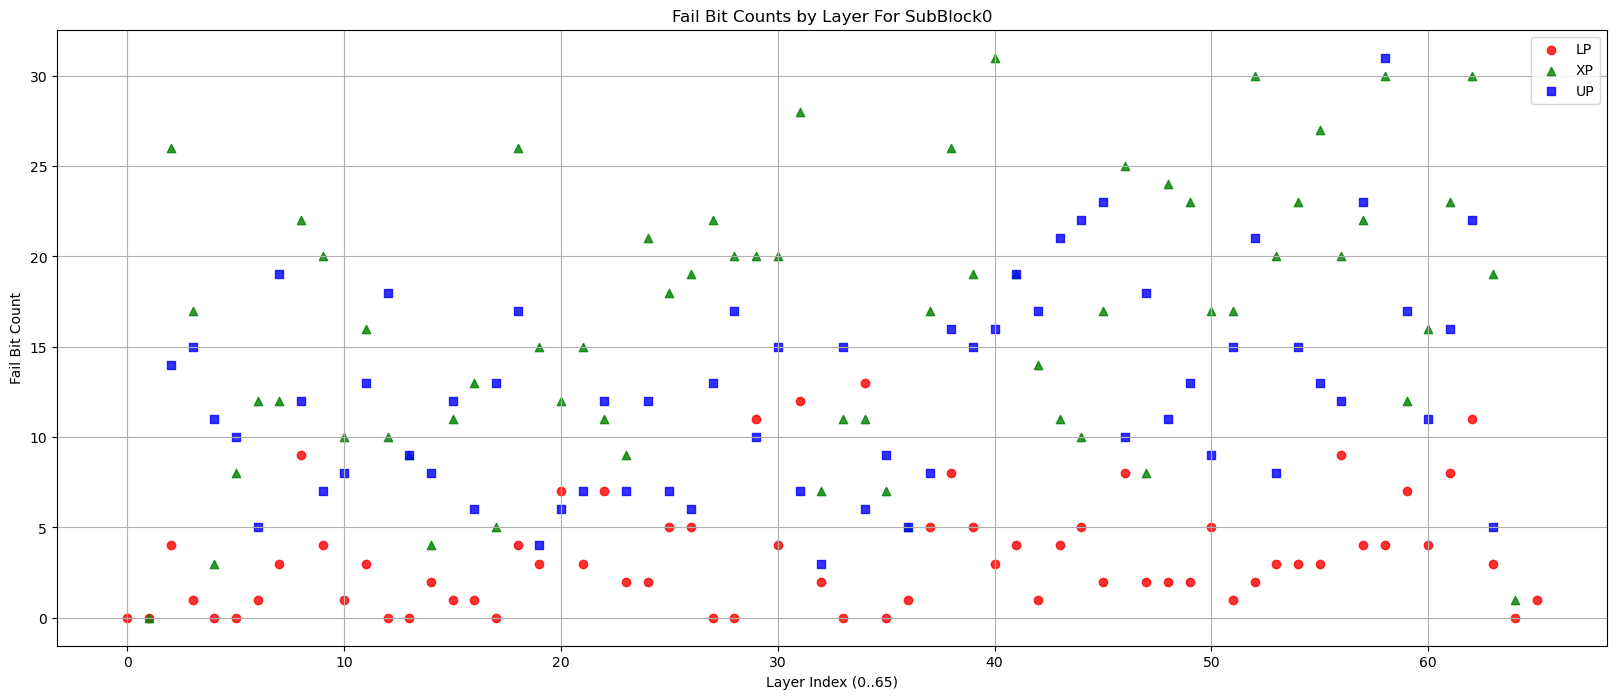

In [89]:
plot_layer_fbc_scatter(fail_counts, layers_66_sb0)

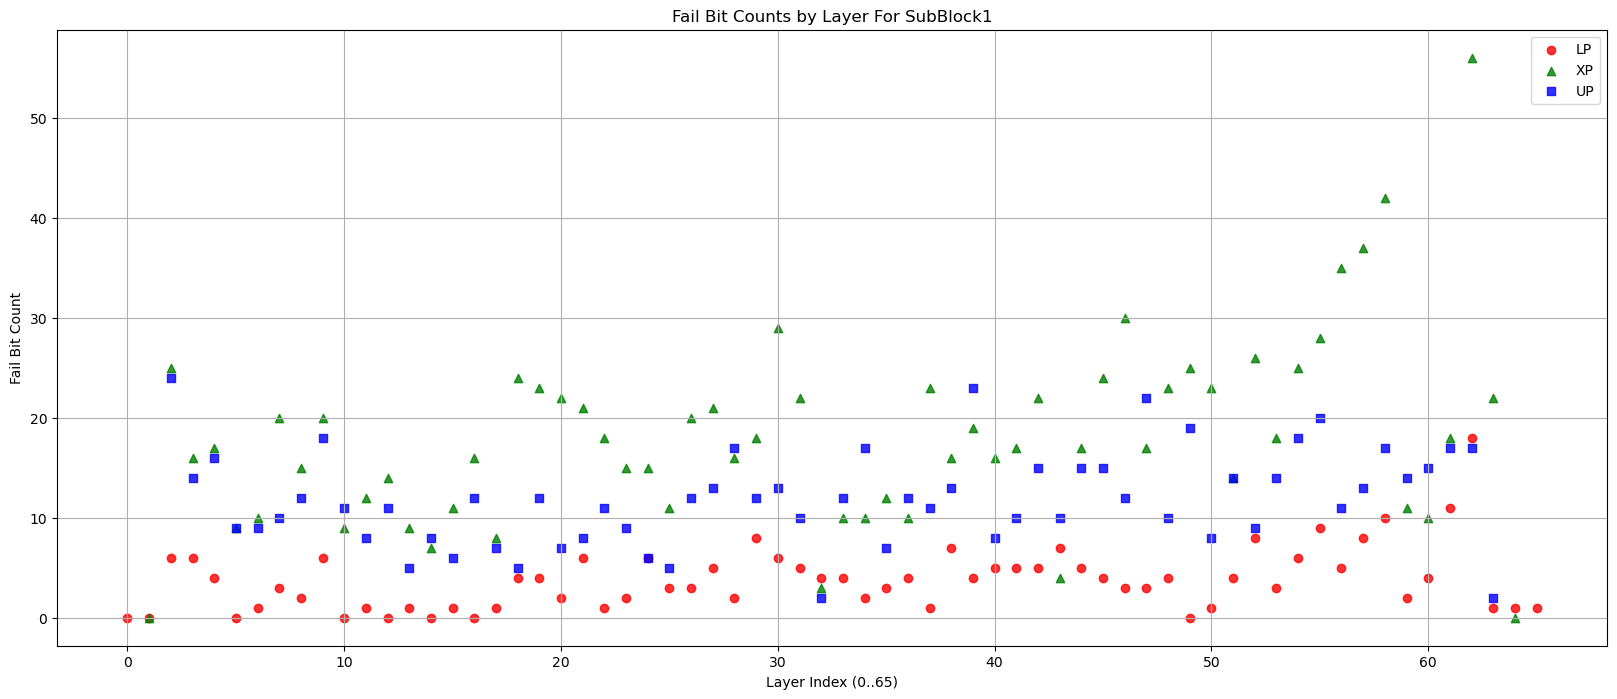

In [86]:
plot_layer_fbc_scatter(fail_counts, layers_66_sb1)

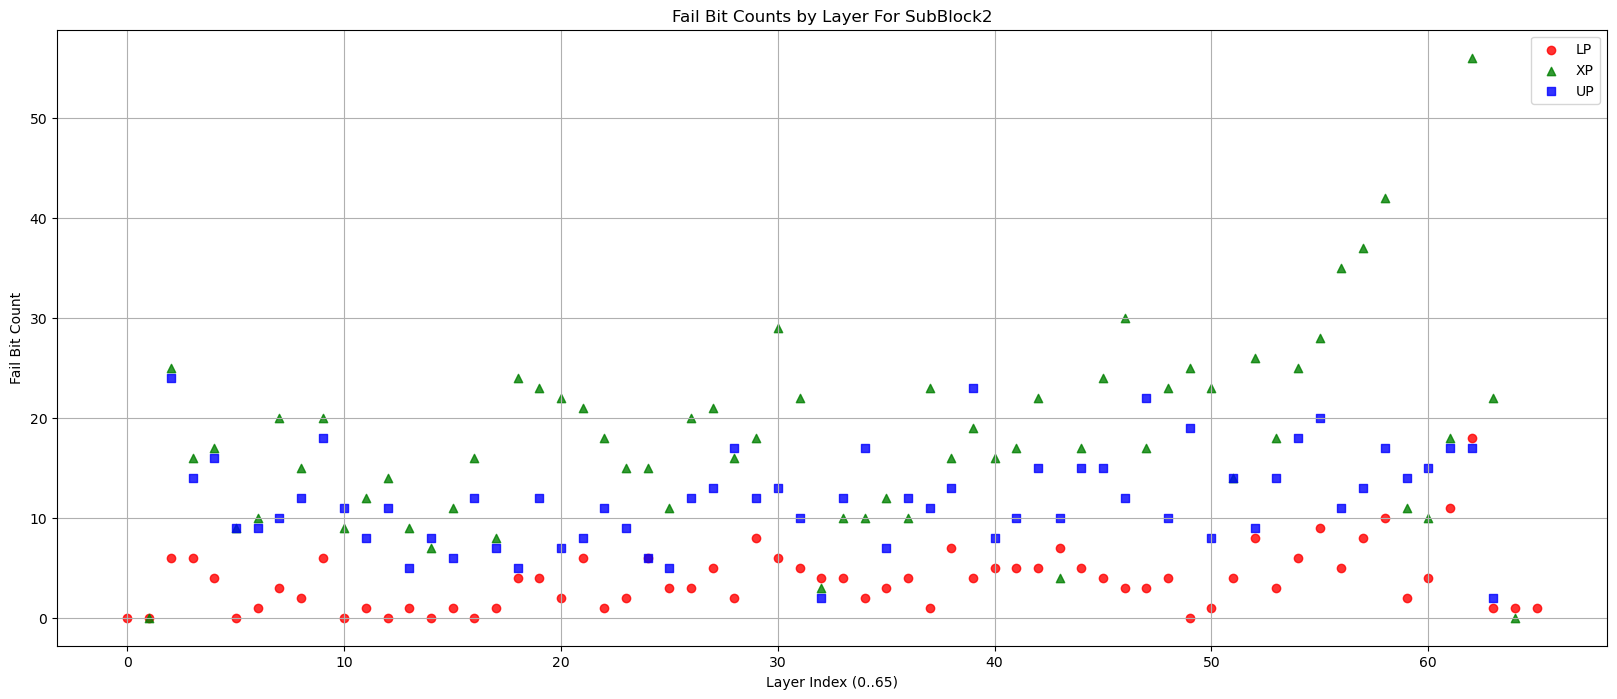

In [84]:
plot_layer_fbc_scatter(fail_counts, layers_66_sb2)

## VT Measurement

In [30]:
#Set feature command
NAND_CMD_SET_FEATURES = 0xEF

In [31]:
# Constants for read offsets Feature Addressses 
rL1_2bpc = 0xA0  # L1 Read Offset for fully programmed MLC WL
rL2_2bpc = 0xA1  # L2 Read Offset for fully programmed MLC WL
rL3_2bpc = 0xA2  # L3 Read Offset for fully programmed MLC WL
rSLC = 0xA4      # SLC Read Offset level for SLC programmed SLC WL
rL1_3bpc = 0xA5  # L1 Read Offset for fully programmed TLC WL
rL2_3bpc = 0xA6  # L2 Read Offset for fully programmed TLC WL
rL3_3bpc = 0xA7  # L3 Read Offset for fully programmed TLC WL
rL4_3bpc = 0xA8  # L4 Read Offset for fully programmed TLC WL
rL5_3bpc = 0xA9  # L5 Read Offset for fully programmed TLC WL
rL6_3bpc = 0xAA  # L6 Read Offset for fully programmed TLC WL
rL7_3bpc = 0xAB  # L7 Read Offset for fully programmed TLC WL
rLP_3bpc = 0xAC  # LP Read Offset for only LP programmed TLC WL

In [32]:
def read_offset_nand(subfeature_value, rLx_xbpc):
    #Command Cycle 1
    cmds1 =  [Ftdi.WRITE_EXTENDED, ACTIVATE_COMMNAD_LATCH, 0] 
    cmds1 += [NAND_CMD_SET_FEATURES]
    
    #Address Cycle 5 Consequtive
    cmds2 = [Ftdi.WRITE_EXTENDED, ACTIVATE_ADDRESS_LATCH, 0 , rLx_xbpc]
   
    #data cycle 
    cmds3 = [Ftdi.WRITE_EXTENDED, DEACTIVATE_CA_LATCH , 0, subfeature_value]
    for i in range(1,4,1):
        cmds3 += [Ftdi.WRITE_SHORT, 0, 0x00]
        
    print(f"Command 1:  {cmds1}")
    print(f"Command 2:  {cmds2}")
    print(f"Command 3:  {cmds3}")
    
    ftdi.write_data(Array('B', cmds1))
    time.sleep(0.01)
    ftdi.write_data(Array('B', cmds2))
    time.sleep(0.01)
    ftdi.write_data(Array('B', cmds3))
    time.sleep(0.01)

In [33]:
#convert linear page address
linearPageAddress = 1
pagesPerBlock = 2304
NumberOfPlane = 2

pageX, blockX, planeX = decode_page_address(linearPageAddress, pagesPerBlock, NumberOfPlane)

print(f"Address {linearPageAddress} => Page {pageX}, Block {blockX}, Plane {planeX}")

Address 1 => Page 1, Block 0, Plane 0


In [34]:
#create address cycle
column = 0
page   = pageX
block  = blockX
plane  = planeX
lun    = 0

#create 5 address cycle
cycles = build_5_cycle_address_tlc(column, page, block, plane, lun)
print(f"Address Cycles: {cycles}")

print("5 Address Cycles:")
for i, val in enumerate(cycles, start=1):
    print(f" Cycle {i}: 0x{val:02X}  (bin: {val:08b})")

Address Cycles: [0, 0, 1, 0, 0]
5 Address Cycles:
 Cycle 1: 0x00  (bin: 00000000)
 Cycle 2: 0x00  (bin: 00000000)
 Cycle 3: 0x01  (bin: 00000001)
 Cycle 4: 0x00  (bin: 00000000)
 Cycle 5: 0x00  (bin: 00000000)


In [46]:
byteLength = 1000

#Send the command and address cycles before page read
read_nand_command(cycles)

#Read byte by byte from Data Register
dataBefore = read_nand_page_bytes(byteLength)
print(dataBefore)

b'\xec\xac\x93\xa1\r\x94\xbe\xd3\x08\xe2\x05\xe7l\xb5\xc686)\xe8\xa3\xe2!\x99"\x9b\x86\xa7\xf2h\xaa.\x1e(\xa7N\xfdn\x95\xf9I\xb4\xc5_\xf6\xe5\x83}\xe2r\x0b\x92|9\xf7=\x86\xb3]\xc9\xed\xc1]E\x83H\xb8BC|m\xcca\xdf\xcd\xfd\x1c\x9a`\x98\xb3"\xb4\x15U\xf7m\x1a$+{A\x82~\x93\xf9\xc6t\x99\xe0\xa24\x12\xf8\x0e\xec;`@\xa0u\xa7^A\xe4x\xd2\xe7D\x9eg\xe4:T\xb0\xa4\xbe1X]-\xd1\xd3(%/\xd2\xfa\xc8=\xc8\xc99!Fm\r\xb5\x12\xeb\xbbA.\xf1\xc2n\x8d\xc47F\x1c\xbc\xa8\xd7mD\xab\xf9\xa7\xe9\xb3$\xa7\x97!/8\xf4\xa5_(\xe7\xd3\xfdE\xc3jD\xbb\xea\x1d\nPk\xcf\x15\x18\xdat\xea\xe5\x9f\xddSp\x82\xbef\x8c\x9cSPz\xd6o\x00p#\xd9\xbc\x94\x83\x05}Z9B:a\x89\xeb\x16\n\xe5\xda\xf1G\xd5V\xb1H:-Tx\x95\xa2\x96\x82fLKy\xfa\xf5)\x17\x91\xc4\xeb\xd2*\xcc\xdbD\x19r\xb9\x9c0\x1d\xb2d\xcc\x00C\xb8([\xfe\x0c\x89u\xce\x83\xa3\x05\xc2\xa0s8\x1bL<v\xb3[\xb1\xadq\xf7- W\xba\xefQ\xee\xa5\x84S\xd2\xe3}\x18\xb7\x1co\xc6\xc7CQ^\xaa\xef\xa4\xdaa\x13\x9b\x12\xc2e\x1a\x13\xe1\xc2\x15\xf3\x8b{\x0bz\xe3\xe3J\xa0\xe2\x077q\xbdu\xc5\xf6t\xcdf>]\xf4\

In [39]:
read_offset_nand(0x6F, rSLC)

Command 1:  [147, 64, 0, 239]
Command 2:  [147, 128, 0, 164]
Command 3:  [147, 0, 0, 111, 146, 0, 0, 146, 0, 0, 146, 0, 0]


In [41]:
status_register_check()

bytearray(b'`')
Status:01100000
Successfully Done!!


In [381]:
ftdi.purge_buffers()
byteLength = 2000

#Send the command and address cycles before page read
read_nand_command(cycles)

#Read byte by byte from Data Register
dataAfter = read_nand_page_bytes(byteLength)
print(dataAfter[204])
print(type(dataAfter))

255
<class 'bytes'>


In [47]:
def nand_read_full_page_tlc(pageno, blockno, PagePerBlock):
    planeno = 0
    pageBytes = 16384
    max_rx_buffer = 4096
    readData = []
    ftdi.purge_buffers()

    addressCycleStream = build_5_cycle_address_tlc(0, pageno, blockno, planeno, 0)
    read_nand_command(addressCycleStream)

    for i in range(0, pageBytes//max_rx_buffer, 1):
        readData += read_nand_page_bytes(max_rx_buffer)
    readData += read_nand_page_bytes(pageBytes%max_rx_buffer)
    return readData

Command 1:  [147, 64, 0, 239]
Command 2:  [147, 128, 0, 164]
Command 3:  [147, 0, 0, 0, 146, 0, 0, 146, 0, 0, 146, 0, 0]
65656
Command 1:  [147, 64, 0, 239]
Command 2:  [147, 128, 0, 164]
Command 3:  [147, 0, 0, 0, 146, 0, 0, 146, 0, 0, 146, 0, 0]
2
Command 1:  [147, 64, 0, 239]
Command 2:  [147, 128, 0, 164]
Command 3:  [147, 0, 0, 1, 146, 0, 0, 146, 0, 0, 146, 0, 0]
3
Command 1:  [147, 64, 0, 239]
Command 2:  [147, 128, 0, 164]
Command 3:  [147, 0, 0, 2, 146, 0, 0, 146, 0, 0, 146, 0, 0]
2
Command 1:  [147, 64, 0, 239]
Command 2:  [147, 128, 0, 164]
Command 3:  [147, 0, 0, 3, 146, 0, 0, 146, 0, 0, 146, 0, 0]
4
Command 1:  [147, 64, 0, 239]
Command 2:  [147, 128, 0, 164]
Command 3:  [147, 0, 0, 4, 146, 0, 0, 146, 0, 0, 146, 0, 0]
6
Command 1:  [147, 64, 0, 239]
Command 2:  [147, 128, 0, 164]
Command 3:  [147, 0, 0, 5, 146, 0, 0, 146, 0, 0, 146, 0, 0]
9
Command 1:  [147, 64, 0, 239]
Command 2:  [147, 128, 0, 164]
Command 3:  [147, 0, 0, 6, 146, 0, 0, 146, 0, 0, 146, 0, 0]
9
Command 1:  

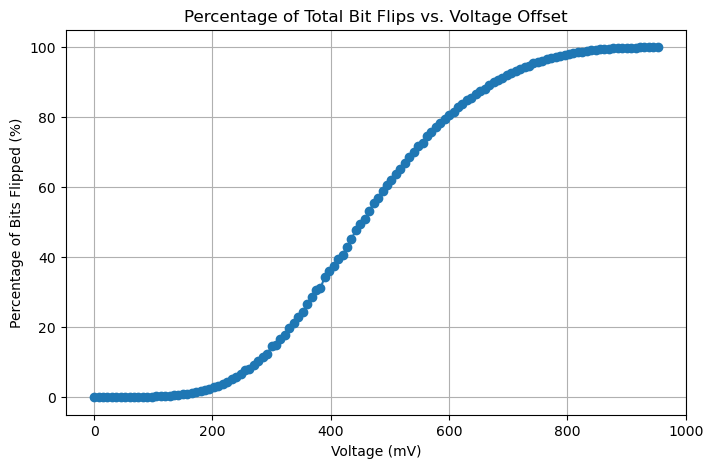

In [422]:
import matplotlib.pyplot as plt


def count_total_bit_flips(ref_bytes, current_bytes):
    
    #Counts how many individual bits differ between ref_bytes and current_bytes.
    #Both ref_bytes and current_bytes should be lists (or arrays) of integers [0..255].
    total_flips = 0
    for rb, cb in zip(ref_bytes, current_bytes):
        diff = rb ^ cb              # XOR the two bytes
        flipped_bits = bin(diff).count('1')  # Count how many bits are '1' in diff
        total_flips += flipped_bits
    print(total_flips)
    return total_flips

def count_zero_bits(byte_val):
    """
    Returns the number of 0 bits in the 8-bit integer byte_val.
    Using Python 3.10's int.bit_count() to count 1 bits,
    then subtract from 8.
    """
    return 8 - byte_val.bit_count()

pageno = 7
blockno = 0
PagePerBlock = 2304
rLx_xbpc = 0

# 1) Read a reference page (list of bytes)
read_offset_nand(0x00, rSLC)
ref_data = nand_read_full_page_tlc(pageno, blockno, PagePerBlock)

total_zero_bits = sum(count_zero_bits(rb) for rb in ref_data)
print(total_zero_bits)

voltages = []
percentage_changes = []

# 2) Loop over subfeature_value from 0 to 0x7F (127)
for subfeature_value in range(0x80):
    read_offset_nand(subfeature_value, rSLC)
    current_data = nand_read_full_page_tlc(pageno, blockno, PagePerBlock)
    # 3) Count total number of flipped bits via XOR
    bit_flips = count_total_bit_flips(ref_data, current_data)

    # Convert to a percentage of total bits
    percent_changed = (bit_flips / total_zero_bits) * 100

    # 4) Each subfeature_value increment => +7.5 mV
    voltage = subfeature_value * 7.5

    voltages.append(voltage)
    percentage_changes.append(percent_changed)


# 5) Plot
plt.figure(figsize=(8, 5))
plt.plot(voltages, percentage_changes, marker='o')
plt.title("Percentage of Total Bit Flips vs. Voltage Offset")
plt.xlabel("Voltage (mV)")
plt.ylabel("Percentage of Bits Flipped (%)")
plt.grid(True)
plt.savefig("CDF.png", dpi=300, bbox_inches='tight')
plt.show()


In [55]:
lsbSharedPage = nand_read_full_page_tlc(12, 0, 2304)
msbSharedPage = nand_read_full_page_tlc(13, 0, 2304)

print("LSB Page Length :", len(lsbSharedPage))
print("MSB Page Length :", len(msbSharedPage))

print(lsbSharedPage)
print(msbSharedPage)

LSB Page Length : 16384
MSB Page Length : 16384
[60, 211, 44, 125, 224, 164, 209, 159, 253, 203, 11, 188, 198, 130, 232, 222, 149, 1, 196, 73, 252, 158, 84, 78, 225, 23, 153, 142, 99, 232, 29, 113, 1, 122, 86, 66, 66, 92, 97, 224, 34, 225, 165, 131, 248, 30, 31, 85, 104, 89, 180, 98, 208, 105, 88, 123, 35, 208, 173, 51, 1, 238, 50, 206, 17, 128, 75, 97, 182, 105, 160, 76, 181, 127, 19, 240, 243, 135, 94, 108, 106, 4, 236, 63, 65, 13, 62, 18, 93, 232, 112, 77, 104, 169, 171, 208, 103, 110, 184, 6, 221, 141, 8, 108, 218, 8, 77, 177, 221, 16, 184, 215, 93, 230, 96, 149, 27, 188, 168, 84, 5, 94, 41, 25, 12, 142, 198, 234, 254, 9, 82, 27, 118, 35, 130, 1, 160, 203, 204, 64, 3, 250, 12, 49, 164, 113, 215, 74, 18, 66, 141, 166, 20, 92, 61, 0, 130, 71, 135, 234, 116, 22, 35, 2, 64, 103, 184, 48, 203, 105, 202, 218, 159, 125, 34, 162, 51, 187, 213, 147, 100, 51, 65, 189, 19, 28, 233, 176, 46, 96, 186, 121, 24, 115, 244, 78, 109, 166, 76, 114, 47, 43, 158, 4, 183, 14, 109, 120, 49, 88, 139, 194,

In [60]:
def combine_lsb_msb(lsb_page, msb_page):
    """
    Combine each byte of an LSB page and an MSB page into a list of 2-bit tuples.
    
    Parameters:
        lsb_page (list of int): Each element is a byte (0..255) from the LSB page.
        msb_page (list of int): Each element is a byte (0..255) from the MSB page.
        
    Returns:
        state_list (list of tuple): List of (lsb_bit, msb_bit) tuples.
                                   The length will be len(lsb_page) * 8.
    """
    assert len(lsb_page) == len(msb_page), "LSB and MSB lists must be the same length."
    
    state_list = []
    for i in range(len(lsb_page)):
        lsb_byte = lsb_page[i]
        msb_byte = msb_page[i]
        
        # Extract bits from the most-significant bit (bit 7) down to the least (bit 0).
        for bit_position in range(7, -1, -1):
            lsb_bit = (lsb_byte >> bit_position) & 1
            msb_bit = (msb_byte >> bit_position) & 1
            state_list.append((msb_bit, lsb_bit))
    
    return state_list


In [63]:
stateList_12_13 = combine_lsb_msb(lsbSharedPage, msbSharedPage)
print(stateList_12_13)
print(len(stateList_12_13))

[(1, 0), (1, 0), (0, 1), (1, 1), (0, 1), (0, 1), (0, 0), (1, 0), (1, 1), (1, 1), (1, 0), (0, 1), (0, 0), (1, 0), (1, 1), (1, 1), (0, 0), (1, 0), (1, 1), (1, 0), (1, 1), (0, 1), (0, 0), (0, 0), (1, 0), (1, 1), (0, 1), (1, 1), (0, 1), (1, 1), (0, 0), (1, 1), (0, 1), (0, 1), (1, 1), (1, 0), (1, 0), (0, 0), (1, 0), (0, 0), (0, 1), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (1, 0), (1, 0), (1, 1), (0, 1), (1, 0), (1, 1), (1, 0), (0, 0), (0, 0), (1, 1), (1, 1), (0, 0), (1, 0), (0, 1), (1, 1), (1, 1), (0, 1), (1, 1), (0, 1), (0, 1), (0, 1), (1, 1), (0, 1), (0, 1), (1, 0), (1, 1), (1, 1), (1, 1), (0, 0), (1, 0), (1, 1), (0, 0), (0, 1), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 1), (0, 1), (1, 1), (1, 0), (0, 1), (1, 1), (1, 1), (0, 1), (0, 0), (1, 0), (1, 1), (0, 1), (0, 0), (0, 0), (1, 0), (0, 1), (1, 1), (0, 0), (1, 1), (0, 0), (0, 0), (1, 0), (1, 0), (0, 0), (1, 1), (0, 0), (0, 1), (0, 1), (1, 1), (1, 0), (0, 1), (1, 0), (0, 0), (1, 0), (1, 1), (1, 1), (0, 0), (1, 1), (1, 1),

In [64]:
def count_mlc_states(state_list):
    """
    Given a list of (lsb_bit, msb_bit) tuples, return a dict
    with the count of each MLC state: L0, L1, L2, L3.
    """

    # Define a mapping from (LSB, MSB) to state label
    state_mapping = {
        (1, 1): "L0",
        (0, 1): "L1",
        (0, 0): "L2",
        (1, 0): "L3",
    }

    # Initialize counts to 0
    counts = {"L0": 0, "L1": 0, "L2": 0, "L3": 0}

    # Go through each cell's bits and increment the corresponding state count
    for (lsb, msb) in state_list:
        # Identify which state it belongs to
        state_label = state_mapping.get((lsb, msb))
        if state_label is not None:
            counts[state_label] += 1
        else:
            # If there's some unexpected bit combination, handle it if needed
            pass

    return counts


In [65]:
# Count how many cells are in each state
result_counts = count_mlc_states(stateList_12_13)

# Print the result
print("MLC state counts:")
for state_label in ["L0", "L1", "L2", "L3"]:
    print(f"  {state_label}: {result_counts[state_label]}")

MLC state counts:
  L0: 32671
  L1: 32959
  L2: 32699
  L3: 32743


In [ ]:
import matplotlib.pyplot as plt


def analyze_mlc_shared_page():
    """
    1) Read the reference LSB and MSB pages.
    2) Combine them into a reference state list.
    3) Count how many are (0,1).
    4) For offsets 0x00 to 0x7F, read again, combine, and find how many changed from (0,1) to (1,1).
    5) Return or plot the percentage (changes / total (0,1)) * 100 vs. offset in mV.
    """
    
    # -- Step 1: Read reference LSB and MSB pages --
    read_offset_nand(0x00, rL1_2bpc)
    lsb_ref = nand_read_full_page_tlc(12, 0, 2304)
    msb_ref = nand_read_full_page_tlc(13, 0, 2304)
    
    # -- Step 2: Combine into reference state list --
    reference_state_list = combine_lsb_msb(lsb_ref, msb_ref)
    print (reference_state_list)
    
    # -- Step 3: Identify total number of cells in (0,1) state in the reference --
    #            We only care about these because we want to see how many changed from (0,1) -> (0,0).
    total_01 = sum(1 for cell in reference_state_list if cell == (0,1))
    if total_01 == 0:
        print("Warning: No cells in (1,0) state in the reference.")
    else :
        print("Total (0,1):" , total_01)
    # Prepare data structures for results
    offsets_mV = []
    percentages_11_to_01 = []
    
    # -- Step 4: Loop over offsets (0x00..0x7F) --
    for subfeature_value in range(0x80):  # 0..127
        # 4a) Read offset LSB/MSB
        read_offset_nand(subfeature_value, rL1_2bpc)
        
        lsb_data_offset = nand_read_full_page_tlc(12, 0, 2304)
        msb_data_offset = nand_read_full_page_tlc(13, 0, 2304)
        
        # 4b) Combine into a state list
        offset_state_list = combine_lsb_msb(lsb_data_offset, msb_data_offset)
        
        # 4c) Count how many reference (0,1) cells have changed to (0,0)
        #     We'll iterate through pairs of (reference_cell, offset_cell).
        changed_10_to_11 = 0
        for ref_cell, off_cell in zip(reference_state_list, offset_state_list):
            if ref_cell == (1, 1) and off_cell == (0,1):
                changed_10_to_11 += 1
        
        # 4d) Calculate the percentage
        if total_01 > 0:
            percentage = (changed_10_to_11 / total_01) * 100
        else:
            percentage = 0.0
        
        # Store result
        voltage_mV = subfeature_value * 7.5  # Each subfeature_value => +7.5 mV
        offsets_mV.append(voltage_mV)
        percentages_11_to_01.append(percentage)
    
    # Return or plot
    return offsets_mV, percentages_11_to_01

Command 1:  [147, 64, 0, 239]
Command 2:  [147, 128, 0, 160]
Command 3:  [147, 0, 0, 0, 146, 0, 0, 146, 0, 0, 146, 0, 0]
[(1, 0), (1, 0), (0, 1), (1, 1), (0, 1), (0, 1), (0, 0), (1, 0), (1, 1), (1, 1), (1, 0), (0, 1), (0, 0), (1, 0), (1, 1), (1, 1), (0, 0), (1, 0), (1, 1), (1, 0), (1, 1), (0, 1), (0, 0), (0, 0), (1, 0), (1, 1), (0, 1), (1, 1), (0, 1), (1, 1), (0, 0), (1, 1), (0, 1), (0, 1), (1, 1), (1, 0), (1, 0), (0, 0), (1, 0), (0, 0), (0, 1), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (1, 0), (1, 0), (1, 1), (0, 1), (1, 0), (1, 1), (1, 0), (0, 0), (0, 0), (1, 1), (1, 1), (0, 0), (1, 0), (0, 1), (1, 1), (1, 1), (0, 1), (1, 1), (0, 1), (0, 1), (0, 1), (1, 1), (0, 1), (0, 1), (1, 0), (1, 1), (1, 1), (1, 1), (0, 0), (1, 0), (1, 1), (0, 0), (0, 1), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 1), (0, 1), (1, 1), (1, 0), (0, 1), (1, 1), (1, 1), (0, 1), (0, 0), (1, 0), (1, 1), (0, 1), (0, 0), (0, 0), (1, 0), (0, 1), (1, 1), (0, 0), (1, 1), (0, 0), (0, 0), (1, 0), (1, 0), (0, 0)

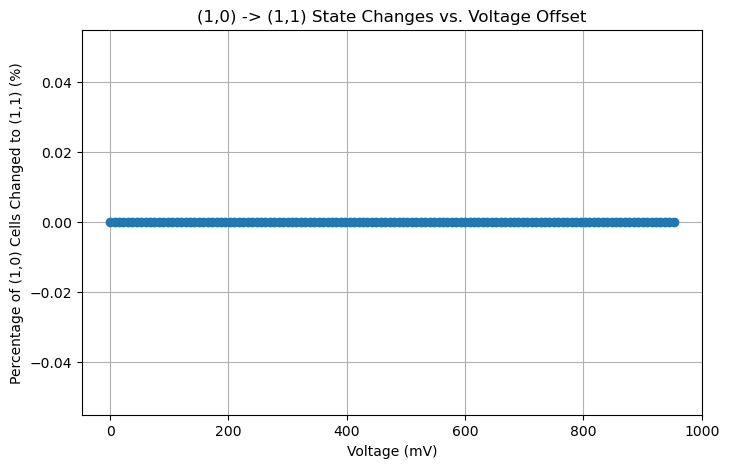

In [77]:
x_vals, y_vals = analyze_mlc_shared_page()

# Plot the result
plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, marker='o')
plt.title("(1,0) -> (1,1) State Changes vs. Voltage Offset")
plt.xlabel("Voltage (mV)")
plt.ylabel("Percentage of (1,0) Cells Changed to (1,1) (%)")
plt.grid(True)
plt.show()
